In [74]:
#adapted from Kaggle (simple LSTM for text classification)
#https://www.kaggle.com/kredy10/simple-lstm-for-text-classification

from __future__ import print_function

import pandas as pd
import numpy as np
np.random.seed(3435) 

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.models import Model, Sequential
from keras.layers import LSTM, Activation, Dense, Dropout, Flatten, Input, Embedding, \
                        Bidirectional, Convolution1D, Conv1D, MaxPooling1D, Input, merge, concatenate
from keras.optimizers import Adam, Adadelta
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.utils import to_categorical, generic_utils
from keras.callbacks import EarlyStopping

# For the recurrent CNN
from keras.regularizers import l2
from keras.layers.recurrent import LSTM, GRU, SimpleRNN
from keras.constraints import maxnorm
# from keras.datasets import imdb
from keras import callbacks
from keras.models import Model
import time

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13242 entries, 0 to 13241
Data columns (total 13 columns):
entry        13242 non-null int64
HITS         13242 non-null int64
KUDOS        13242 non-null int64
TAGS         13242 non-null object
ID_NUMBER    13242 non-null int64
TEXT         13242 non-null object
TITLE        13242 non-null object
WORDCOUNT    13242 non-null int64
MAINTAG      13242 non-null object
SUMMARY      12506 non-null object
COMMENTS     13242 non-null int64
DATE         13242 non-null object
BOOKMARKS    13242 non-null int64
dtypes: int64(7), object(6)
memory usage: 1.3+ MB
13242
Counter({'General Audiences': 3496, 'Teen And Up Audiences': 3434, 'Mature': 3170, 'Explicit': 3142})


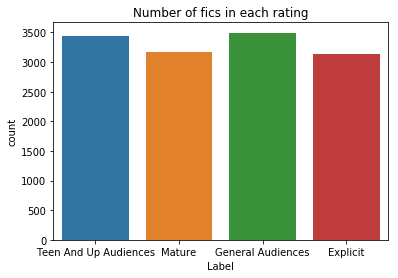

In [130]:
# read in data
df = pd.read_csv("ccrecords.tsv",delimiter='\t',encoding='latin-1')
df.head()
df.info()

print(df.shape[0])
print(Counter(df.MAINTAG))
# plot
sns.countplot(df.MAINTAG)
plt.xlabel('Label')
plt.title('Number of fics in each rating')
plt.show()

In [76]:
# get input and label vectors
X = df.TEXT
print(X.shape)

Y = df.MAINTAG
print(Y.shape)

le = LabelEncoder()
Y = le.fit_transform(Y)
Y = Y.reshape(-1,1)

print(Y.shape)
print(X[1])
print(Y)


(13242,)
(13242,)
(13242, 1)
-	'Babe?' -	'Oh... You know what Billie? Bite me...' -	You know you shouldn't be this angry -	Still she doesn't seem to understand that you need space -	'Babe...' -	You slam the door to your shared room behind you -	Sink down into the corner -	Let your ch
[[3]
 [3]
 [3]
 ...
 [0]
 [0]
 [0]]


In [77]:
# take both columns
XX =  df[['TEXT','SUMMARY', 'TAGS', 'KUDOS', 'HITS']]
print(XX.shape)

Xt = XX.TAGS
print(Xt.shape)

#split into training and test sets
XX_train, XX_test, Y_train, Y_test = train_test_split(XX, Y, test_size=0.10)

Y_train = to_categorical(Y_train, num_classes=4)
Y_test = to_categorical(Y_test, num_classes=4)

print(XX_train.shape)
print(Y_train.shape)
print(XX_test.shape)
print(Y_test.shape)

X_train = XX_train.TEXT
X_test = XX_test.TEXT
Xs_train = XX_train.SUMMARY
Xs_test = XX_test.SUMMARY
Xt_train = XX_train.TAGS
Xt_test = XX_test.TAGS
print(Xt_train.shape)
print(XX_train.KUDOS.shape)
print(XX_train.HITS.shape)

(13242, 5)
(13242,)
(11917, 5)
(11917, 4)
(1325, 5)
(1325, 4)
(11917,)
(11917,)
(11917,)


In [78]:
# parameters, for TEXT
max_len = 200
tok = Tokenizer(lower=True) # default
tok.fit_on_texts(X_train) 
max_words = len(tok.word_index.items()) + 1 # vocab size
print(max_words)

# makes padded sequences so all inputs are of the same length
sequences = tok.texts_to_sequences(X_train)
sequences_matrix = sequence.pad_sequences(sequences, maxlen=max_len)
print(sequences_matrix.shape)
print()

57314
(11917, 200)



In [79]:
# to replace 'nan' with space as this is causing the SUMMARY to be a float object
#test_series = Xs_train.fillna(value='', inplace=False)
Xs_train.fillna(value='', inplace=True)
Xs_test.fillna(value='', inplace=True)

In [80]:
# parameters, for SUMMARY
max_lens = 50
toks = Tokenizer(lower=True) # default lower case = true
toks.fit_on_texts(Xs_train) # str(X_train)
max_wordss = len(toks.word_index.items()) + 1 # vocal size, all words from all these stories? seems very small
print(max_wordss)

# makes padded sequences so all inputs are of the same length
seq2 = toks.texts_to_sequences(Xs_train)
seq_mat2 = sequence.pad_sequences(seq2, maxlen=max_lens)
print(seq_mat2.shape)

19143
(11917, 50)


In [81]:
# parameters, for TAGS
max_lent = 50
tokt = Tokenizer(filters='!"#$%()*+,-.:;<=>?@[\\]^_`{|}~\t\n', lower=True) # default lower = true
tokt.fit_on_texts(Xs_train) # str(X_train)
max_wordst = len(tokt.word_index.items()) + 1 # vocal size, all words from all these stories? seems very small
print(max_wordst)

# makes padded sequences so all inputs are of the same length
seq3 = tokt.texts_to_sequences(Xt_train)
seq_mat3 = sequence.pad_sequences(seq3, maxlen=max_lent)
print(seq_mat3.shape)

19678
(11917, 50)


In [82]:
# get glove embeddings for TEXT, use max_words and tok.word_index.items
embeddings_index = dict()
f = open('glove.6B.100d.txt', encoding="utf8")

for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
    
f.close()
embedding_matrix = np.zeros((max_words,100))

for word,i in tok.word_index.items():
    print(word)
    print(i)
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

the
1
and
2
to
3
his
4
a
5
he
6
of
7
you
8
in
9
'
10
her
11
it
12
i
13
was
14
that
15
she
16
as
17
him
18
â 
19
with
20
on
21
for
22
is
23
but
24
at
25
this
26
had
27
they
28
be
29
not
30
up
31
me
32
my
33
so
34
when
35
out
36
like
37
your
38
from
39
all
40
into
41
one
42
just
43
have
44
back
45
what
46
eyes
47
down
48
no
49
are
50
them
51
would
52
over
53
their
54
do
55
it's
56
if
57
said
58
time
59
were
60
by
61
could
62
then
63
there
64
now
65
more
66
about
67
can
68
know
69
love
70
or
71
an
72
before
73
how
74
been
75
hand
76
around
77
never
78
against
79
don't
80
even
81
will
82
too
83
only
84
get
85
i'm
86
we
87
head
88
again
89
way
90
didn't
91
face
92
other
93
still
94
hands
95
off
96
through
97
here
98
after
99
see
100
want
101
who
102
he's
103
'i
104
lips
105
has
106
did
107
away
108
right
109
fingers
110
than
111
go
112
always
113
little
114
much
115
himself
116
something
117
because
118
good
119
make
120
first
121
bed
122
come
123
mouth
124
think
125
body
126
long
127
going

1147
placed
1148
'this
1149
curled
1150
fighting
1151
returned
1152
fault
1153
surprised
1154
cause
1155
lord
1156
glanced
1157
rain
1158
daddy
1159
spine
1160
cup
1161
thin
1162
realized
1163
haven't
1164
luke
1165
other's
1166
ian
1167
missed
1168
lady
1169
beauty
1170
wrist
1171
touches
1172
wrists
1173
note
1174
lovely
1175
lifted
1176
touching
1177
pair
1178
paper
1179
early
1180
mad
1181
kid
1182
order
1183
drop
1184
ways
1185
star
1186
la
1187
office
1188
flowers
1189
lightly
1190
listening
1191
blanket
1192
lives
1193
sir
1194
'not
1195
ah
1196
bag
1197
opening
1198
welcome
1199
sexy
1200
share
1201
tip
1202
m
1203
younger
1204
city
1205
calling
1206
round
1207
lust
1208
opens
1209
mess
1210
remus
1211
whenever
1212
partner
1213
eating
1214
'if
1215
blade
1216
fair
1217
below
1218
stretched
1219
alex
1220
muttered
1221
special
1222
color
1223
tone
1224
six
1225
hurts
1226
universe
1227
'come
1228
battle
1229
bloody
1230
peace
1231
dad
1232
'are
1233
sea
1234
enjoyed
1235
places

knock
2397
swollen
2398
obvious
2399
boy's
2400
george
2401
allowing
2402
chat
2403
one's
2404
hang
2405
clutching
2406
spilling
2407
law
2408
confusion
2409
hopefully
2410
friendship
2411
zeke
2412
al
2413
giggles
2414
hook
2415
puppy
2416
shudders
2417
bought
2418
darcy
2419
chloe
2420
twist
2421
parted
2422
scorpius
2423
throws
2424
footsteps
2425
sand
2426
counter
2427
danger
2428
olivia
2429
test
2430
glistening
2431
chuckle
2432
spit
2433
literally
2434
stairs
2435
pansy
2436
squeeze
2437
locks
2438
ribs
2439
snorted
2440
features
2441
tv
2442
speed
2443
hint
2444
giant
2445
horror
2446
curling
2447
'did
2448
g
2449
goodbye
2450
spider
2451
ignoring
2452
stolen
2453
'stiles
2454
massive
2455
http
2456
knelt
2457
knowledge
2458
movements
2459
kicked
2460
re
2461
23
2462
member
2463
chose
2464
sting
2465
clouds
2466
cell
2467
cloud
2468
horse
2469
w
2470
raises
2471
woods
2472
heal
2473
imagining
2474
flush
2475
jonathan
2476
holy
2477
lingering
2478
climax
2479
broad
2480
echoed
2

3146
thumbs
3147
study
3148
misaki
3149
bread
3150
trained
3151
beard
3152
fans
3153
shaped
3154
blind
3155
papers
3156
meal
3157
flick
3158
ben's
3159
hyung
3160
violence
3161
sated
3162
lace
3163
porn
3164
whines
3165
strike
3166
clutched
3167
potter's
3168
tub
3169
giles
3170
26
3171
slapped
3172
sacrifice
3173
cloth
3174
equally
3175
grips
3176
cousin
3177
blank
3178
tossing
3179
site
3180
ian's
3181
gesture
3182
current
3183
multiple
3184
fond
3185
inspired
3186
fics
3187
mickey
3188
diana
3189
amber
3190
corn
3191
frodo
3192
molly
3193
starsky
3194
duck
3195
sora
3196
johnlock
3197
rocked
3198
'she
3199
fragile
3200
boyfriend's
3201
freezing
3202
cups
3203
sob
3204
waste
3205
sobbing
3206
recent
3207
root
3208
silky
3209
pretending
3210
mumbles
3211
desert
3212
'for
3213
jesus
3214
flowing
3215
pit
3216
'have
3217
exact
3218
prefer
3219
occasionally
3220
maria
3221
presents
3222
favor
3223
damage
3224
twitched
3225
pleading
3226
considering
3227
hunt
3228
jay
3229
pen
3230
hood
3

3896
height
3897
slicked
3898
'alright
3899
brendon
3900
prime
3901
incredible
3902
willingly
3903
healthy
3904
swept
3905
hawke
3906
fanfiction
3907
washing
3908
vince
3909
army
3910
tradition
3911
weep
3912
stray
3913
wildly
3914
exquisite
3915
connected
3916
zack
3917
misses
3918
teases
3919
robot
3920
thorin
3921
lance's
3922
cliff
3923
daehyun
3924
hatter
3925
medic
3926
board
3927
layers
3928
bruising
3929
glory
3930
sunset
3931
vulcan
3932
grazing
3933
aches
3934
pleaded
3935
carlos
3936
weakness
3937
flicking
3938
betrayed
3939
slams
3940
reflected
3941
rude
3942
hotter
3943
captured
3944
squirm
3945
wetness
3946
ability
3947
lately
3948
cuffs
3949
humor
3950
candles
3951
taehyung
3952
crushed
3953
meat
3954
earned
3955
holidays
3956
wars
3957
posts
3958
daisy
3959
mental
3960
mystery
3961
bending
3962
court
3963
guards
3964
saving
3965
provide
3966
proceeded
3967
claire
3968
'god
3969
daryl
3970
tilting
3971
bat
3972
yanked
3973
forming
3974
maggie
3975
adrenaline
3976
useful


mika
4646
slippery
4647
dip
4648
springs
4649
bitten
4650
instincts
4651
bomb
4652
showers
4653
'me
4654
novel
4655
lowering
4656
strain
4657
helplessly
4658
bunk
4659
cats
4660
restless
4661
bakugou
4662
nonetheless
4663
slam
4664
thread
4665
squeaked
4666
ties
4667
oblivion
4668
sixteen
4669
latter
4670
performance
4671
nasty
4672
freckles
4673
rumble
4674
limits
4675
hesitated
4676
tattoos
4677
spoon
4678
originally
4679
misery
4680
worthless
4681
bucked
4682
partner's
4683
nsfw
4684
pitched
4685
mister
4686
splayed
4687
passionately
4688
suggestion
4689
'hmm
4690
bruce's
4691
clasped
4692
england
4693
rapidly
4694
secure
4695
gate
4696
momentarily
4697
shrug
4698
marble
4699
impressed
4700
console
4701
butâ¦
4702
temptation
4703
incident
4704
abs
4705
impatient
4706
shoots
4707
growling
4708
potential
4709
crossing
4710
mistakes
4711
pierced
4712
design
4713
woken
4714
avoiding
4715
meanwhile
4716
crouched
4717
fluffy
4718
mortal
4719
bedside
4720
climbing
4721
issues
4722
restaur

calming
5396
missions
5397
beamed
5398
handing
5399
charms
5400
dipping
5401
daylight
5402
adoration
5403
upward
5404
nostrils
5405
pounds
5406
highly
5407
strangers
5408
bane
5409
dumbledore
5410
stilled
5411
battles
5412
pliant
5413
punched
5414
undressed
5415
protective
5416
ugh
5417
melts
5418
included
5419
alert
5420
petting
5421
remus's
5422
snuggling
5423
legacy
5424
git
5425
adjusted
5426
served
5427
regard
5428
colder
5429
climbs
5430
traveling
5431
hardest
5432
basement
5433
it'
5434
foster
5435
tank
5436
hilt
5437
symbol
5438
matches
5439
dove
5440
nonsense
5441
enthusiastic
5442
trembles
5443
dizzy
5444
searched
5445
slaps
5446
haunt
5447
ladies
5448
gabe
5449
earn
5450
planted
5451
banging
5452
stings
5453
blossom
5454
upside
5455
throb
5456
crowded
5457
cradle
5458
grim
5459
paws
5460
prompts
5461
concrete
5462
option
5463
charged
5464
stormed
5465
occasional
5466
poetry
5467
underground
5468
peacefully
5469
longest
5470
justâ¦
5471
sway
5472
seth
5473
fenris
5474
tickle

6145
wendell
6146
poem
6147
nuzzles
6148
pumped
6149
lapping
6150
diner
6151
lil
6152
online
6153
elves
6154
elder
6155
ivy
6156
invite
6157
landscape
6158
medicine
6159
banner
6160
necks
6161
require
6162
homework
6163
elrond
6164
tuned
6165
specifically
6166
gesturing
6167
champion
6168
engine
6169
sack
6170
powerless
6171
cradling
6172
snuggle
6173
bug
6174
'ok
6175
tickles
6176
adores
6177
zombie
6178
duo
6179
malfoy's
6180
sixth
6181
intimacy
6182
organs
6183
nudging
6184
thrilled
6185
twilight
6186
column
6187
sole
6188
fliss
6189
soâ¦
6190
hesitantly
6191
shakily
6192
hoodie
6193
loyal
6194
soda
6195
knotted
6196
alight
6197
depressed
6198
patting
6199
separated
6200
thy
6201
terms
6202
fascinating
6203
42
6204
mycroft's
6205
snarl
6206
secured
6207
bees
6208
regretted
6209
council
6210
ingredients
6211
spy
6212
insult
6213
cuddles
6214
tang
6215
float
6216
nothingness
6217
snoring
6218
tailor
6219
shuts
6220
concentrate
6221
prior
6222
classroom
6223
lingers
6224
arguing
6225


6895
'think
6896
wee
6897
blonde's
6898
emerged
6899
official
6900
prefers
6901
widening
6902
'nice
6903
unnatural
6904
itch
6905
vera
6906
fox's
6907
companions
6908
net
6909
tumbled
6910
alicia
6911
rigid
6912
drying
6913
throbbed
6914
troll
6915
'something
6916
wives
6917
howls
6918
mixing
6919
'john
6920
robbie
6921
punching
6922
privilege
6923
swan
6924
static
6925
rips
6926
tilt
6927
glove
6928
treating
6929
lubricant
6930
nut
6931
resisted
6932
cooed
6933
grade
6934
creaked
6935
railing
6936
dorm
6937
andrew
6938
scotty
6939
bo
6940
snout
6941
cj
6942
depth
6943
adoring
6944
poised
6945
partially
6946
sync
6947
colin
6948
smashed
6949
encounter
6950
world's
6951
rocket
6952
viewing
6953
pig
6954
bumps
6955
scrape
6956
scented
6957
stores
6958
liquor
6959
56
6960
pleasurable
6961
dungeon
6962
valentine
6963
dangling
6964
altogether
6965
urgency
6966
thorough
6967
doubted
6968
shortly
6969
unpleasant
6970
alisanne
6971
corset
6972
martha
6973
scales
6974
inappropriate
6975
magenta

recalls
7645
erza
7646
explodes
7647
aisle
7648
fumbled
7649
throaty
7650
avoided
7651
tiles
7652
y'all
7653
hawke's
7654
stomped
7655
paddle
7656
rumor
7657
striking
7658
epilogue
7659
fleeing
7660
flinches
7661
interrupts
7662
primal
7663
tinged
7664
fetch
7665
tinsel
7666
cuphead
7667
paths
7668
texts
7669
anduin
7670
oral
7671
attacks
7672
cord
7673
pointedly
7674
relatively
7675
hoarsely
7676
wig
7677
moons
7678
intensely
7679
rammed
7680
life's
7681
abbey
7682
muffle
7683
sauntered
7684
strains
7685
floral
7686
audible
7687
'merlin
7688
successfully
7689
coward
7690
erase
7691
neutral
7692
gulps
7693
pulsed
7694
vehicle
7695
alas
7696
appreciative
7697
monday
7698
vibrant
7699
brittle
7700
lillith
7701
congratulations
7702
appreciatively
7703
zac
7704
obedience
7705
commit
7706
ma'am
7707
wilson's
7708
pleas
7709
men's
7710
sally
7711
woah
7712
splashed
7713
shatters
7714
incredulous
7715
bears
7716
sickening
7717
expectantly
7718
huffing
7719
jungle
7720
'too
7721
dudes
7722
che

oiled
8395
keened
8396
madame
8397
sensing
8398
welcomes
8399
fuckin
8400
jan
8401
edmund
8402
urged
8403
hover
8404
sarcastic
8405
meaningless
8406
ââ 
8407
affectionate
8408
psycho
8409
dennis
8410
interrupt
8411
typing
8412
dots
8413
that'
8414
creaking
8415
bile
8416
wantonly
8417
revelation
8418
percival
8419
ego
8420
galra
8421
retrieve
8422
straddles
8423
realm
8424
dusk
8425
understatement
8426
sangwoo
8427
clint's
8428
sickness
8429
assholes
8430
teachers
8431
active
8432
injury
8433
flavored
8434
iii
8435
bitches
8436
acceptance
8437
comfy
8438
baka
8439
charmed
8440
erratic
8441
threaded
8442
helpful
8443
blocking
8444
peaked
8445
obscured
8446
exhausting
8447
lalli
8448
whistling
8449
snuggles
8450
drums
8451
vengeance
8452
scum
8453
singer
8454
potent
8455
cologne
8456
surround
8457
dj
8458
foundation
8459
pics
8460
script
8461
eerie
8462
handcuffed
8463
'time
8464
madison
8465
scratchy
8466
requires
8467
mating
8468
dey
8469
'aww
8470
stabbing
8471
gansey
8472
plates
84

9144
hipbones
9145
yawning
9146
ooo
9147
monstrous
9148
flaming
9149
scolded
9150
geoffrey
9151
showered
9152
fondling
9153
helena's
9154
bronze
9155
lmao
9156
noses
9157
clex
9158
silhouette
9159
vine
9160
courtship
9161
sucker
9162
basis
9163
flex
9164
biceps
9165
inexperienced
9166
scooted
9167
suite
9168
'may
9169
angelina
9170
flopping
9171
obediently
9172
dom's
9173
betraying
9174
blossoming
9175
ebony
9176
dee
9177
radiating
9178
cement
9179
ignite
9180
poker
9181
relax'â¦
9182
rear
9183
'you'd
9184
lustful
9185
ranks
9186
ghoul
9187
lacing
9188
slicing
9189
drifts
9190
faith's
9191
native
9192
astonishment
9193
ditch
9194
sub
9195
scanning
9196
cazziel
9197
disappoint
9198
ackles
9199
hideous
9200
mahiru
9201
reflects
9202
supreme
9203
basketball
9204
masked
9205
slope
9206
haul
9207
observe
9208
experiencing
9209
tummy
9210
breathtaking
9211
callused
9212
areas
9213
betas
9214
stuffing
9215
fathers
9216
forge
9217
collect
9218
approve
9219
competition
9220
referring
9221
atho

9894
miserably
9895
span
9896
thickly
9897
selina
9898
spike's
9899
rar
9900
infirmary
9901
thrashing
9902
salem
9903
suitable
9904
dub
9905
endearing
9906
foe
9907
robb
9908
produced
9909
obedient
9910
gaped
9911
beckoning
9912
princesses
9913
swells
9914
conner
9915
gruff
9916
outward
9917
spitting
9918
tsukishima's
9919
hints
9920
chisato
9921
legged
9922
elena
9923
deafening
9924
grumble
9925
garcia
9926
natsu
9927
glossy
9928
disease
9929
blooms
9930
vase
9931
stiffened
9932
weaving
9933
interrupting
9934
bladder
9935
shaken
9936
tenth
9937
roused
9938
80
9939
appeal
9940
swatted
9941
pronounced
9942
lacy
9943
gmail
9944
husbands
9945
exotic
9946
bobbi
9947
attending
9948
dish
9949
advisor
9950
oyster
9951
anal
9952
greystagg
9953
amy's
9954
wolfgang
9955
frenchbread
9956
sheep
9957
blasting
9958
fragrant
9959
korea
9960
mystical
9961
caboose
9962
males
9963
starsk
9964
yelps
9965
recipe
9966
reassurance
9967
craig
9968
jeon
9969
'which
9970
tadashi
9971
bonnie's
9972
legit
9973
â

shushed
10644
slickness
10645
zhanying's
10646
sphere
10647
hallucinating
10648
deanna
10649
pleasured
10650
splinters
10651
owed
10652
defy
10653
garnet
10654
linen
10655
alleyway
10656
aoi
10657
gregory
10658
sergeant
10659
arrange
10660
roxy
10661
nimble
10662
doesnt
10663
imaginary
10664
wilderness
10665
whack
10666
phineas
10667
significant
10668
daydream
10669
fiamma
10670
cheryl
10671
kinder
10672
gnomes
10673
triggers
10674
proceed
10675
network
10676
tegoshi
10677
embraces
10678
daytime
10679
solemn
10680
memorial
10681
kyo
10682
wretched
10683
bedtime
10684
darlin
10685
blackened
10686
neo
10687
cockpit
10688
akechi
10689
suspenders
10690
darren's
10691
hiro
10692
boromir
10693
kooh
10694
bloodshed
10695
joel
10696
strictly
10697
turtle
10698
underworld
10699
hark
10700
trips
10701
pyro
10702
elven
10703
dipper's
10704
toni
10705
swish
10706
highness
10707
hump
10708
advanced
10709
spooned
10710
padme
10711
naught
10712
albus's
10713
kirishima
10714
ursula
10715
klaus
10716
h

pitcher
11394
archangel
11395
sparkles
11396
yuki's
11397
explosions
11398
glue
11399
perky
11400
bridal
11401
breathily
11402
syllables
11403
rejoice
11404
libra
11405
venom's
11406
cyrus
11407
asahi
11408
unwrapped
11409
noodle
11410
nora
11411
log
11412
plopped
11413
candies
11414
gloom
11415
deer
11416
flakes
11417
rider
11418
toph
11419
clumsily
11420
slutty
11421
blaring
11422
'soâ¦
11423
ruelle
11424
xx
11425
php
11426
duh
11427
carded
11428
tozier
11429
guessing
11430
twined
11431
foods
11432
decaying
11433
caves
11434
vegetables
11435
maeglin
11436
likeâ¦
11437
2nd
11438
len's
11439
enveloping
11440
steak
11441
endlessly
11442
recognised
11443
alluring
11444
'iâ¦
11445
lenny
11446
sentences
11447
revive
11448
dresser
11449
recognise
11450
favorites
11451
despised
11452
dulled
11453
separation
11454
penelope
11455
stadium
11456
poles
11457
futile
11458
yamaguchi's
11459
disapproval
11460
unravel
11461
swipes
11462
velvety
11463
crafted
11464
glinted
11465
ai
11466
succeed
11

12143
tinky
12144
winky
12145
nicolas
12146
ded
12147
shush
12148
yuffie
12149
scenario
12150
tread
12151
pursuit
12152
mesmerised
12153
clouding
12154
lolling
12155
stony
12156
reactor
12157
colouring
12158
disinterest
12159
lacks
12160
vanity
12161
swooped
12162
muzzle
12163
pouch
12164
dryly
12165
brilliance
12166
disapprove
12167
hand's
12168
secretary
12169
vividly
12170
chirping
12171
latex
12172
miki
12173
ceases
12174
jo's
12175
girls'
12176
celebrations
12177
farkle
12178
splits
12179
creeps
12180
davies
12181
explores
12182
â no
12183
hee
12184
sidney
12185
restraining
12186
glisten
12187
nepeta
12188
evenly
12189
trudged
12190
simmering
12191
patched
12192
bulk
12193
chime
12194
chiseled
12195
monitor
12196
goo
12197
earshot
12198
irrational
12199
camping
12200
motherfucker
12201
tremor
12202
goaded
12203
shreds
12204
opalsong
12205
otp
12206
shippers
12207
podficcing
12208
carnal
12209
hawt
12210
mah
12211
megatron's
12212
hurtful
12213
eliott
12214
vibrate
12215
'captain
1

12893
'quiet
12894
lan
12895
do'
12896
'forever
12897
hectic
12898
superheroes
12899
advantages
12900
thundering
12901
drowsy
12902
prodded
12903
greets
12904
jyuugo
12905
devilishly
12906
oswald's
12907
''i'm
12908
contours
12909
urgently
12910
ornate
12911
polishing
12912
orphans
12913
ushered
12914
input
12915
sprinkles
12916
devils
12917
scorned
12918
chirped
12919
imitation
12920
girlish
12921
precinct
12922
o'neill
12923
gritty
12924
chirp
12925
havent
12926
updates
12927
scrutiny
12928
jerky
12929
respectful
12930
clash
12931
filtering
12932
beckon
12933
'nevermind
12934
garter
12935
mustache
12936
frustrations
12937
smartest
12938
donâ´t
12939
recommended
12940
filming
12941
compromise
12942
palmed
12943
unblinking
12944
tutor
12945
behaving
12946
unused
12947
transforms
12948
solved
12949
hushing
12950
sallysparrow017
12951
backâ¦
12952
ford's
12953
insert
12954
crescendo
12955
designer
12956
eventual
12957
soâ 
12958
resists
12959
luminescent
12960
positively
12961
layla
129

shack
13643
sigurd
13644
arvis
13645
hunch
13646
unto
13647
korean
13648
tww100
13649
education
13650
hued
13651
fidgeted
13652
persuasion
13653
adequate
13654
camelot
13655
indulging
13656
masturbate
13657
saunders
13658
risking
13659
persisted
13660
reinhardt
13661
await
13662
enchanting
13663
ordeal
13664
remainder
13665
qualities
13666
dent
13667
unknowing
13668
twirls
13669
application
13670
flute
13671
bolder
13672
pollen
13673
sentient
13674
bodyguard
13675
scenarios
13676
dm
13677
cooperate
13678
ll
13679
flatulence
13680
needless
13681
seiichi
13682
unhealthy
13683
sept
13684
futures
13685
ulith
13686
demeanor
13687
bigfoot
13688
offspring
13689
slur
13690
bush
13691
punk
13692
services
13693
bathe
13694
cycles
13695
pawn
13696
felix's
13697
slot
13698
hose
13699
majority
13700
lunatic
13701
bloodstained
13702
mendeleev
13703
ballroom
13704
soot
13705
radiated
13706
lady's
13707
wilkins
13708
sweatshirt
13709
bokuto
13710
busting
13711
receives
13712
mixcloud
13713
canes
13714

vulva
14393
sprayed
14394
dodge
14395
babe'
14396
wrecking
14397
earnestly
14398
dreadful
14399
maglor
14400
rejection
14401
setzer
14402
helpfully
14403
pilot's
14404
mummy
14405
'yes'
14406
smother
14407
cadence
14408
reed
14409
starred
14410
pomfrey
14411
conceived
14412
intertwine
14413
collaboration
14414
estimated
14415
extinguished
14416
rainstorm
14417
compensate
14418
lounged
14419
jabs
14420
dawning
14421
keybum
14422
ð
14423
plz
14424
'it'sâ¦
14425
fumes
14426
'youâ¦
14427
utters
14428
safeword
14429
branded
14430
clasping
14431
tingled
14432
scheming
14433
aperture
14434
spectacle
14435
coitus
14436
vegan
14437
wrench
14438
amateur
14439
tendons
14440
phones
14441
sorry'
14442
substitute
14443
preoccupied
14444
particles
14445
reproduce
14446
rodimus'
14447
weirder
14448
thine
14449
âto
14450
outlet
14451
amore
14452
wobbling
14453
thatâ 
14454
sniffling
14455
backdrop
14456
psychotic
14457
tab
14458
manipulative
14459
rosa
14460
buttery
14461
seduced
14462
excite
14

15142
yellowed
15143
wavered
15144
deirdre
15145
dwarves
15146
'crash
15147
lyn's
15148
conveniently
15149
justâ 
15150
burr
15151
mmmmmm
15152
misunderstood
15153
'keith
15154
turbulent
15155
offending
15156
'h
15157
deity
15158
pits
15159
foremost
15160
sunrises
15161
jaal
15162
abandons
15163
int
15164
euphemism
15165
garments
15166
lass
15167
skov
15168
volatile
15169
cancelled
15170
matrix
15171
marcy
15172
manipulating
15173
blazed
15174
nya
15175
thundered
15176
dusky
15177
undeserving
15178
bellowing
15179
dupain
15180
aoba
15181
downfall
15182
clip
15183
inked
15184
shitting
15185
shenanigans
15186
ooc
15187
musa's
15188
â with
15189
morosely
15190
inventions
15191
creations
15192
layed
15193
butthole
15194
geoffrey's
15195
selves
15196
repressed
15197
apparated
15198
'everything's
15199
foil
15200
braden
15201
fink
15202
'tomorrow
15203
wwe
15204
stash
15205
chap
15206
adoringly
15207
babygirl
15208
bishops
15209
colorado
15210
messenger
15211
kuro
15212
beckons
15213
eyepatc

15892
tribe
15893
carrots
15894
halsey
15895
silhouettes
15896
lend
15897
crow's
15898
noel
15899
backpack
15900
adulthood
15901
select
15902
ambassadors
15903
joon
15904
graduated
15905
nagi
15906
millburn
15907
superficial
15908
fezzik
15909
suckled
15910
lara
15911
wrenches
15912
ptsd
15913
hybrids
15914
eleanor's
15915
craning
15916
retract
15917
studious
15918
nikki
15919
bran
15920
ruling
15921
quietness
15922
ghirahim
15923
mayhem
15924
orli
15925
postmodern
15926
jukebox
15927
grell's
15928
sewn
15929
exiting
15930
willow's
15931
interruption
15932
zach's
15933
pippin
15934
robotic
15935
knox
15936
lbs
15937
kg
15938
chapstick
15939
garona
15940
taria
15941
wonwoo
15942
mcnuggie
15943
kiran
15944
surveying
15945
nooooo
15946
buff
15947
nik
15948
fu
15949
undying
15950
goods
15951
tybalt
15952
peniop
15953
boats
15954
dreading
15955
evolve
15956
tit
15957
hal's
15958
wang
15959
luka's
15960
brunette's
15961
crowe
15962
'we'd
15963
unmarked
15964
seimei
15965
ritsuka's
15966
ako


olli
16634
paulie
16635
finland
16636
meaningfully
16637
keladryb
16638
yteen
16639
tww100's
16640
sacrificing
16641
additions
16642
yakuza
16643
shat
16644
taboo
16645
others'
16646
redheaded
16647
concubine
16648
surf
16649
alleys
16650
pry
16651
geez
16652
mills
16653
fazed
16654
hardship
16655
embodied
16656
requesting
16657
dissipates
16658
digimon
16659
valar
16660
battled
16661
uni
16662
filters
16663
maneuvers
16664
gapes
16665
denies
16666
unconcerned
16667
lucius'
16668
exaggeration
16669
erupt
16670
ragnarok
16671
cluster
16672
disconnect
16673
overcoming
16674
communicating
16675
chanyeol's
16676
mauled
16677
soubi's
16678
cloying
16679
balor
16680
circus
16681
flair
16682
withâ 
16683
handshake
16684
heightened
16685
donna's
16686
ravished
16687
genocide
16688
founders
16689
ruefully
16690
bottomed
16691
fussed
16692
phoebe
16693
riches
16694
cav
16695
atsushi
16696
corruption
16697
connects
16698
pooch
16699
benches
16700
cascading
16701
sero
16702
sears
16703
horcrux
167

17891
'boss
17892
rebuild
17893
gowns
17894
jere
17895
coupling
17896
â ss
17897
descendants
17898
sharpness
17899
shaven
17900
captivated
17901
yields
17902
gratification
17903
ariel
17904
targets
17905
unconventional
17906
distractedly
17907
hazama
17908
prop
17909
reallyâ¦
17910
'much
17911
dark's
17912
kili
17913
worriedly
17914
twit
17915
feltâ¦
17916
swarm
17917
enrico
17918
highs
17919
bluish
17920
refreshing
17921
soulmate's
17922
sols
17923
alcove
17924
dichotomy
17925
lulling
17926
'hermione
17927
accompanying
17928
scissoring
17929
wreckage
17930
discrete
17931
arcs
17932
templar
17933
sumptuous
17934
burger'
17935
plunder
17936
quid
17937
plight
17938
kifumi
17939
elemental
17940
businesses
17941
redness
17942
discard
17943
enraptured
17944
butch
17945
narration
17946
arcade
17947
junction
17948
consort
17949
shirou's
17950
elisa
17951
aesthetic
17952
'mother
17953
m4v
17954
boughs
17955
oppressive
17956
âfuck
17957
broomstick
17958
clinical
17959
stationed
17960
headli

18738
swaggy
18739
quartermaster
18740
gadreel's
18741
decus
18742
donghyuck's
18743
zoisite
18744
hanschen
18745
merula
18746
fick
18747
dolph
18748
hounds
18749
adz
18750
midday
18751
vormoncrief
18752
ganondorf
18753
psyduck
18754
restlessly
18755
hild
18756
hounddog
18757
lucyinthesky
18758
arther's
18759
surgeon's
18760
andrea's
18761
leyla
18762
xalina
18763
caribou
18764
beanson
18765
hellboy
18766
veeti
18767
jaakko's
18768
'ahâ¦
18769
stomp
18770
uploaded
18771
koushi
18772
maker's
18773
ronda
18774
starch
18775
janos
18776
weston
18777
tomas
18778
njada
18779
leviathans
18780
copia
18781
camisole
18782
osomatsu
18783
âbabe
18784
rematch
18785
parrotfish
18786
kebab
18787
wast
18788
seizure
18789
meld
18790
detectivedimples
18791
gaysonscott
18792
traveler
18793
qi'ra
18794
jobas
18795
tsp
18796
11001000
18797
hp
18798
naoto's
18799
zeon
18800
commodore's
18801
phila's
18802
hawks
18803
chumps
18804
amilyn's
18805
badboyjail
18806
maric
18807
patty
18808
shinya
18809
haaâ¦

headlong
19391
lusty
19392
identifying
19393
gibson's
19394
puffing
19395
infancy
19396
garters
19397
soaks
19398
teenaged
19399
emptying
19400
manhattan
19401
reclining
19402
crevice
19403
dormitories
19404
occurring
19405
melinda's
19406
teardrop
19407
wholesome
19408
startlingly
19409
vacant
19410
rappa
19411
babysit
19412
tearful
19413
webcam
19414
justâ
19415
spinner
19416
thisâ
19417
sor
19418
cassio
19419
venice
19420
bravest
19421
colombia
19422
lunge
19423
ruse
19424
methodically
19425
carey
19426
debts
19427
bets
19428
'friday
19429
bunker's
19430
dormitory
19431
harries
19432
shimada
19433
mounds
19434
paddy
19435
bargain
19436
cons
19437
rearranged
19438
silverstreak
19439
unfurl
19440
yamato's
19441
amulet
19442
'sorry'
19443
varda
19444
blurt
19445
yourâ 
19446
zarkon
19447
lickable
19448
sneezes
19449
fiendfyre
19450
depended
19451
wreath
19452
despicable
19453
notions
19454
cal's
19455
fleck
19456
pectorals
19457
abel
19458
ambrose
19459
jey
19460
uso
19461
mobster


harrowing
20141
thi
20142
garbled
20143
uther's
20144
goblet
20145
caterwauling
20146
companionship
20147
inclining
20148
pipboy
20149
promotion
20150
savoured
20151
berate
20152
grandfather's
20153
portraits
20154
declaring
20155
mikey's
20156
qunari
20157
refer
20158
'other
20159
uncharacteristic
20160
rn
20161
yara
20162
sifting
20163
collision
20164
fay
20165
'charming
20166
facepalmed
20167
hanger
20168
yixing
20169
luhan
20170
'calm
20171
mutated
20172
toâ
20173
barcelona
20174
unsatisfied
20175
harshness
20176
kuryakin
20177
nightmarish
20178
bordered
20179
toolbelt
20180
dramione
20181
xxx
20182
afro
20183
unforgivable
20184
pretty'
20185
hadâ¦
20186
boston
20187
jia
20188
laidback
20189
aaah
20190
bulged
20191
monster's
20192
'pleaseâ¦
20193
external
20194
fest
20195
dears
20196
stability
20197
cadets
20198
avert
20199
eloquently
20200
inconvenience
20201
aesthetically
20202
apprehensive
20203
unfolded
20204
bosom
20205
sams
20206
resolutely
20207
moustache
20208
exasperat

20890
timelines
20891
cobbled
20892
glenda's
20893
baton
20894
foresee
20895
entrusted
20896
coincide
20897
weasleywench
20898
yeh
20899
beethoven
20900
ledger
20901
tinkling
20902
ballerina
20903
insidious
20904
cimorene
20905
unsanitary
20906
'nico
20907
chafed
20908
damsel
20909
sulk
20910
empties
20911
seruel's
20912
villanelle's
20913
fencing
20914
ânow
20915
jumpsuit
20916
mirax
20917
'couldn't
20918
rigel
20919
guv
20920
skype
20921
redacted
20922
twister
20923
crookshanks
20924
ponds
20925
quips
20926
kevlar
20927
noâ 
20928
walrider
20929
snarky
20930
siberia
20931
soundless
20932
vomited
20933
caving
20934
panicky
20935
iâ
20936
eloquence
20937
traits
20938
azumane
20939
youngsters
20940
2005
20941
existential
20942
unbind
20943
welfare
20944
typhoon
20945
pathfinder
20946
drack
20947
protoform
20948
'ahhh
20949
aluminium
20950
rending
20951
feigned
20952
jumpy
20953
priorities
20954
obligations
20955
partake
20956
scraggly
20957
callaghan
20958
sybil's
20959
ailicec
2096

21640
brides
21641
digest
21642
flaps
21643
seventies
21644
overtakes
21645
blade's
21646
vending
21647
'precisely
21648
aranea's
21649
swarming
21650
'their
21651
scrunches
21652
featherlight
21653
'mmh
21654
lightwood
21655
trustworthy
21656
mp4b
21657
bids
21658
fudge
21659
mulled
21660
elenwã«
21661
'deanâ¦'
21662
restricted
21663
nâno
21664
outloud
21665
hã©lã¨ne
21666
lovelace
21667
firefighter
21668
indra
21669
cormac
21670
shire
21671
rly
21672
dud
21673
lunchtime
21674
mels
21675
sam'
21676
satan's
21677
olde
21678
scuttling
21679
cgi
21680
babes
21681
cellmate
21682
dab
21683
frayach
21684
teas
21685
mb4
21686
blanco
21687
hoon
21688
capped
21689
tana
21690
gendry
21691
onesie
21692
scrunch
21693
vassilissa
21694
beetle
21695
yesss
21696
94
21697
enduring
21698
confinement
21699
'liar
21700
enoughâ¦
21701
yuugi's
21702
turd
21703
shelly
21704
pinterest
21705
loveliness
21706
them'
21707
shrimpy
21708
1942
21709
raunchy
21710
waterproof
21711
yogurt
21712
tix
21713
lok
217

scorpio
22640
suradanna
22641
monch
22642
ethel
22643
chews
22644
maddest
22645
misunderstanding
22646
kurosawa
22647
fictionfreak15
22648
dankey
22649
malik
22650
fractured
22651
kã­li's
22652
crispin
22653
untidy
22654
cesc
22655
professor'
22656
vocalizer
22657
wanteddoa
22658
brit's
22659
utensils
22660
maud
22661
armitage
22662
fusco
22663
harris
22664
estimation
22665
cured
22666
canâ´t
22667
zoned
22668
noooobody
22669
myrtle
22670
thesus
22671
iceland
22672
metis
22673
xalina's
22674
dainn
22675
hokage
22676
aobas
22677
elma
22678
elma's
22679
gakuto
22680
bunks
22681
liu
22682
kidney
22683
daigo
22684
pietro's
22685
'thomas
22686
rea
22687
yebin
22688
yebin's
22689
'shhhh
22690
keg's
22691
intersexed
22692
genitalia
22693
maureen's
22694
art's
22695
habit's
22696
cepan
22697
worrisome
22698
seeley
22699
â¦
22700
guang
22701
agnes
22702
na'toth
22703
g'kar
22704
senator
22705
'art
22706
ermine
22707
adaar
22708
todomatsuâ¦
22709
bancoran
22710
vivien
22711
joshua
22712
hyunggu

teardrops
23559
argh
23560
rain's
23561
owner's
23562
plaguing
23563
wishful
23564
stuffie
23565
sadist
23566
male's
23567
saidâ
23568
spinner's
23569
'jay
23570
off'
23571
dispassionate
23572
desdemona
23573
othello
23574
molars
23575
âsee
23576
nealer's
23577
sum
23578
complacent
23579
eodrakken
23580
pantyhose
23581
naomi's
23582
reopened
23583
baepsaejerrie
23584
mercedes
23585
yelping
23586
drought
23587
harrying
23588
averted
23589
shimadacest
23590
â genji
23591
kinkshame
23592
giveaway
23593
leche
23594
recuerdos
23595
unanticipated
23596
â sweet
23597
callestah
23598
deviations
23599
forum
23600
barrels
23601
dublin
23602
officers'
23603
tumbleweed
23604
laziness
23605
deadlock
23606
thoracic
23607
svu
23608
nightcap
23609
declaimer
23610
huskier
23611
claudia's
23612
briefings
23613
funding
23614
air'
23615
berating
23616
ââ 
23617
wrongness
23618
clubbing
23619
adorn
23620
inspection
23621
boost
23622
immunity
23623
cowardice
23624
vehemently
23625
discern
23626
arguab

24139
'dave
24140
demonstrating
24141
munchies
24142
mortality
24143
warlord
24144
lunches
24145
retracting
24146
snikt
24147
asgard's
24148
ra9
24149
deviated
24150
charade
24151
dornfelder
24152
chiding
24153
stormtrooper
24154
trooper
24155
sunlit
24156
âdoesn't
24157
blueâ¦
24158
d'eon
24159
lia
24160
mete
24161
guardian's
24162
meanders
24163
bunsen
24164
myst
24165
mamma
24166
interviews
24167
uncomprehending
24168
leela's
24169
hitherto
24170
kokichi's
24171
fun'
24172
waka's
24173
havve
24174
insulated
24175
dinah's
24176
sayâ¦
24177
want'
24178
lassiter
24179
wades
24180
fondles
24181
volition
24182
grizzly
24183
fanzone
24184
prowl's
24185
blanks
24186
culminated
24187
challange
24188
suckers
24189
â make
24190
exhibitionism
24191
mailboxes
24192
whitened
24193
building's
24194
undignified
24195
'nii
24196
escorting
24197
reread
24198
muddle
24199
meyrin
24200
scotsman
24201
may've
24202
beards
24203
pattrose
24204
thing'
24205
fanwork
24206
cascades
24207
lexâ 
24208
dom

25139
merrill
25140
merrill's
25141
groban
25142
odysseus
25143
proceeding
25144
observatory
25145
voluntarily
25146
abubble
25147
superstition
25148
tractors
25149
stardom
25150
broadway
25151
neighbour
25152
cultures
25153
frankenstein
25154
hind
25155
reservation
25156
nordic
25157
traversed
25158
caricature
25159
squawking
25160
grievous
25161
murderer's
25162
cinders
25163
conceive
25164
393
25165
66
25166
gb
25167
mpreg
25168
drumbeat
25169
thedas
25170
light's
25171
loaned
25172
snowmen
25173
angelo
25174
clearness
25175
pita
25176
sheathed
25177
loophole
25178
dangle
25179
peripheral
25180
â look
25181
midsection
25182
tweaked
25183
unlaced
25184
outrealm
25185
onoda
25186
pidge's
25187
levity
25188
yeild
25189
starkly
25190
millimetres
25191
compass
25192
mituna
25193
mitaka
25194
greece
25195
accurately
25196
beneficial
25197
monumental
25198
brandishing
25199
brackets
25200
kes'
25201
vin's
25202
ebbed
25203
clinic
25204
ruthlessly
25205
39am
25206
47am
25207
48am
25208
qual

jerusalem
26139
putty
26140
spans
26141
anniversaries
26142
consequential
26143
defused
26144
airplanes
26145
capitol
26146
baddies
26147
bestdayever
26148
capt
26149
drafting
26150
heinkel
26151
â an
26152
portrayal
26153
hallow
26154
replicated
26155
rus
26156
overseeing
26157
purples
26158
slouch
26159
soulmark
26160
likewise
26161
rigged
26162
pents
26163
kis
26164
xddd
26165
bender
26166
toshinori's
26167
disbanded
26168
oui
26169
bluebells
26170
velocity
26171
fitness
26172
siren's
26173
haywire
26174
richly
26175
kix
26176
cutters
26177
lineup
26178
requirement
26179
fetishist
26180
vantas
26181
browsing
26182
sappho
26183
kreacher
26184
sulked
26185
burrito
26186
'mattie
26187
deviancy
26188
prides
26189
harms
26190
rupert's
26191
sobered
26192
candlelit
26193
dingle
26194
enchanter
26195
orsino
26196
invocation
26197
gallows
26198
lurker
26199
wagers
26200
gawk
26201
chute
26202
ladylike
26203
adapting
26204
â made
26205
lida
26206
tokoyami
26207
'true'
26208
cromcnh
26209
'th

beserk
27139
tenderized
27140
gn
27141
hus
27142
thu
27143
darn
27144
tyres
27145
imladris
27146
referencing
27147
shorn
27148
v's
27149
sinning
27150
anchoring
27151
whoop
27152
blackjack
27153
aâ'
27154
âgroup
27155
shurii
27156
taces
27157
pf
27158
rhe
27159
csme
27160
cummed
27161
kore
27162
melkor
27163
'hyeong
27164
âgoodbye
27165
eyeballing
27166
decisively
27167
porthole
27168
lilah's
27169
showgirl
27170
fred's
27171
squat
27172
braving
27173
roadmap
27174
1hr
27175
shebang
27176
dru's
27177
horrifically
27178
inflame
27179
wretchedly
27180
haves
27181
chak
27182
sienna
27183
hollowness
27184
steves
27185
replyed
27186
kallus
27187
trumpets
27188
whys
27189
greenhouses
27190
overworked
27191
transgender
27192
abernathy
27193
â black
27194
excites
27195
jody's
27196
admonished
27197
gerald
27198
varr
27199
keenly
27200
guiltily
27201
'except
27202
redden
27203
creepiness
27204
underdressed
27205
hooker
27206
'slow
27207
mermaid's
27208
vessel's
27209
indescreet
27210
skil

keane
28121
jayhawks
28122
greyscale
28123
frightens
28124
brawl
28125
ailinel
28126
âhave
28127
âtake
28128
undefeated
28129
pillowy
28130
bunching
28131
sasame's
28132
sasame
28133
evening's
28134
cheavy
28135
countess
28136
â from
28137
untried
28138
jamming
28139
slander
28140
unabridged
28141
passages
28142
scuffed
28143
weapon's
28144
steenie
28145
buckingham's
28146
sophomore
28147
machine's
28148
''last
28149
aid''
28150
broader
28151
mcrae
28152
mashup
28153
kylie
28154
minogue
28155
lovers'
28156
regime
28157
googles
28158
archambault
28159
seijuro's
28160
thorfinn
28161
rowle
28162
dolohov
28163
deathday
28164
rabastan's
28165
ballora
28166
technician
28167
crumbly
28168
categorise
28169
rosã©
28170
umâ¦
28171
kanna
28172
births
28173
afterbirth
28174
linvro21
28175
honoured
28176
'gosh
28177
abigail's
28178
lowe
28179
preslai182
28180
noya's
28181
rewrites
28182
fooling
28183
flo
28184
calculate
28185
hamid's
28186
ango's
28187
trot
28188
divider
28189
'needy
28190
mal

arryn
29638
tully
29639
frontal
29640
'live
29641
'beautiful'
29642
cookin'
29643
accounting
29644
alone'
29645
relevance
29646
chins
29647
tangent
29648
jus'
29649
can'
29650
sawbones
29651
drift's
29652
carnivorous
29653
cuter
29654
singed
29655
relinquish
29656
fellating
29657
rein
29658
magnifying
29659
armyâ¦seven
29660
vimes
29661
organizing
29662
duaroughs
29663
townsfolk
29664
childrenâ¦
29665
hives
29666
chiming
29667
dejected
29668
narnians
29669
eruption
29670
expansive
29671
nightclothes
29672
clown's
29673
bootiful
29674
kaidoh
29675
joanna's
29676
wallpapers
29677
wallhaven
29678
originals
29679
1280
29680
knkwrtr
29681
ambiguous
29682
kateandromeda
29683
sub's
29684
joanne's
29685
hike
29686
lelouch's
29687
seashells
29688
haji
29689
aaahh
29690
costa
29691
'neat
29692
'rachel
29693
n7
29694
composer
29695
v'ger
29696
waned
29697
wallked
29698
chare
29699
belive
29700
ino's
29701
pistoned
29702
yugi
29703
mutou
29704
dirtiest
29705
alexis
29706
irresistibly
29707
atoms

steele
30638
oboe
30639
soliloquy
30640
avdol
30641
freiri
30642
comeing
30643
doijan
30644
darf
30645
fimfiction
30646
009
30647
appleloosan
30648
craaaaazy
30649
pegasister
30650
literary
30651
clop
30652
braâ and
30653
â succ
30654
'mish
30655
disembarks
30656
unsurprising
30657
grooves
30658
tsked
30659
invaluable
30660
aquamarines
30661
shortages
30662
felony
30663
landâ¦
30664
soulâ¦
30665
infuseâ¦
30666
toeing
30667
noonans
30668
appraisingly
30669
'hyungâ'
30670
'boooo
30671
'ahhhhh
30672
jooonnie
30673
marinated
30674
âthe
30675
âfinn
30676
ireland
30677
wadey
30678
fangirling
30679
natering
30680
dnt
30681
agn
30682
ssshhhhhhh
30683
keybumâ ð
30684
ãããããã
30685
uâ still
30686
râ uâ still
30687
'now's
30688
'earthlings
30689
atreus
30690
fairâ¦'
30691
sorrow'
30692
'zophie
30693
crayton's
30694
mogs
30695
soo
30696
zophie's
30697
loric
30698
uncommonly
30699
mimic'd
30700
'jongup
30701
yoonsun
30702
nug
30703
couldn''t
30704
sunburst
30705
'creators
30

31637
âthen
31638
reaffirming
31639
spastic
31640
florentine
31641
emelia
31642
sinews
31643
allege
31644
blaspheme
31645
indent
31646
chomp
31647
jot
31648
âeverythingâ¦'
31649
âtreats'
31650
âtricks'
31651
daasgrrl
31652
shamelessmash
31653
lending
31654
whit's
31655
nealer
31656
gapped
31657
jerkoff
31658
jussi
31659
alphard's
31660
cregg
31661
diapers
31662
'joe
31663
'painting
31664
â https
31665
instigate
31666
posterity
31667
âdistracted'
31668
teenager's
31669
spiderling
31670
paolo
31671
missâ'
31672
'leftâ¦or
31673
herds
31674
circuiting
31675
harrily
31676
twidling
31677
maferath
31678
eijirou
31679
youâah
31680
avoresmith
31681
â explicit
31682
aircrafts
31683
'terrence
31684
102mb
31685
210mb
31686
brotherâcharlie
31687
charlie'd
31688
outâwhich
31689
stayedâ¦
31690
moonsmusings
31691
'minor'
31692
calla
31693
'quickie
31694
dark'
31695
horseguards
31696
contests
31697
treasureâ¦
31698
eyesâ¦yes
31699
entererd
31700
'bishop
31701
affection's
31702
ki

littleâ¦'
32634
saluting
32635
ladyflowdi
32636
8450
32637
walkin
32638
broan
32639
officer's
32640
phonecall
32641
'closer
32642
severusâ¦
32643
'fuckâ¦'
32644
hobbies
32645
febreezeâ¢
32646
wobbles
32647
â â â â â â â â â â â â â 
32648
erron's
32649
âholding
32650
friendsâand
32651
shelley's
32652
zhang
32653
zhong
32654
jian
32655
doughs
32656
distibuted
32657
fruuoooooooze
32658
fuuuuck
32659
yosaf's
32660
'mioâfuck
32661
dying'
32662
funny'
32663
'party
32664
â
32665
florescent
32666
pension
32667
kensi
32668
gamut
32669
â 'someone's
32670
smoothies
32671
metaphorsâ¦is
32672
callen's
32673
deeks'
32674
kensi's
32675
â 'nope
32676
bedsprings
32677
sabretooth's
32678
piston
32679
doncha
32680
â 'we've
32681
ofâ âfucks'
32682
andâ âshits'
32683
thecommrade
32684
definitively
32685
proactive
32686
'floaty
32687
roasted
32688
timesâa
32689
thereâbut
32690
pornâ¦
32691
foamy
32692
dizzied
32693
harderâ¦
32694
devolved
32695
upstroke
32696
organizationally
32697
â

unadorned
33387
countrymen
33388
ilium
33389
rat11
33390
tenhn
33391
ebecame
33392
unicon
33393
cooll
33394
ssaaddd
33395
unuicornnnnnn
33396
seeemssssss
33397
deppresesed
33398
andd
33399
llyed
33400
eyyeye
33401
thenn
33402
mehh
33403
menn
33404
octagon
33405
roughhhhhhhhhhhhhhhhh
33406
2121
33407
beacuse
33408
anâ assassin
33409
lifeâ¦'
33410
toâ continue
33411
littleâ vacation
33412
â moya
33413
lyubov'
33414
â fuckâ 
33415
skateparkâthe
33416
kickturn
33417
thinkâ 
33418
â prince
33419
â ken
33420
â knight
33421
starsâno
33422
â leave
33423
bertolt's
33424
reacclimatize
33425
onâ âactive
33426
duty'
33427
âbond'
33428
permissible
33429
patternâ¦
33430
pliantly
33431
'hugo
33432
'dripping
33433
â¦of
33434
sisterâ¦are
33435
hapâ¦
33436
savedâ¦iâ¦
33437
'izzy
33438
'clary
33439
rewound
33440
stealthy
33441
nightingale's
33442
discontentment
33443
chared
33444
gauntletâ on
33445
ashed
33446
accidentallyâ murdered
33447
âdoctor
33448
âwith
33449
shelved
33450
ruminat

èµµå¯å¹³å®å¨æ¯ç±æ­»äºè¿ä¸ªå§¿å¿ï¼ä»ä½ä¸å¤´å¨åè¿çè©èä¸åå»ï¼æ¶ä¸æ¶çå®å¸åºå ä¸ªçå°åºæ¥ï¼æ¯å¬ä¸å£å¯¹æ¹çå°ç©´ä¼¼ä¹å°±ç´§å¼ çæ¶ç¼©ä¸ä¸ï¼èµµå¯å¹³è¦è¢«ä»é¼ç¯ï¼éªäºä¸å¥éªè´§ï¼ç ç æä½ä»çè°èº«ç ç é¡¶æèµ·æ¥ã
34387
ææ©æ£å°±ææ©æ£å§ï¼ç¡ä¸¹è±ä¸æ­»ï¼åä»ä¹ä¹é£æµã
34388
'æãæ²¡ææä½ å½æææ©æ£â¦â¦'åè¿è¿å¨æ§çäºååçè¯é¢ï¼è¯é½è¯´ä¸å®æ´ï¼è¢«ä½åæå¥½çå¹´è½»äººåçæ­»æ­»çï¼å»åå£°æ­æ­ç»­ç»­ï¼å¸¦çæ³£é³ï¼'æä¸ç¥éï¼åâ¦â¦æå½ä½ æ¯ï¼è½»ãè½»ç¹â¦â¦'
34389
'é£ä½ ææå½ä»ä¹ï¼ä½ è¯´ã'èµµå¯å¹³åå¨ä»æè¦å½çé£ä¸ªå°æ¹ï¼ä¼¸ææ¡ä½äºåè¿å æ¬²çåçæ§å¨ï¼å¯¹æ¹ååºä¸å£°ä¸ç¥æ¯çè¦è¿æ¯ææ¦çå»åã
34390
å¿«è¦çåçéå£è¢«äººæ®å¿çå µä½ï¼èä½åçå¥ä¾µèä»ç¶æ¶å£çæµå¨èºç¹ä¸ä¸è¯å¨å¼¹ï¼åè¿è¢«æç£¨çç¥å¿ä¸æ¸ï¼æäºå´©æºçå­åºå£°æ¥ï¼'æççä¸ç¥éï¼æ±ä½

35386
flatts
35387
chainsmokers
35388
amarante
35389
â¥â¥â¥
35390
ithaca
35391
charybdis
35392
sorceresses
35393
helios
35394
circe's
35395
absolve
35396
communicators
35397
embellished
35398
reynolds
35399
pippa's
35400
rukongai
35401
ichigo's
35402
'hear
35403
tractor
35404
tsn
35405
â 'your
35406
â 'in
35407
'reverse
35408
heelers
35409
uninjured
35410
headfirst
35411
mythos
35412
series'
35413
sapiosexual
35414
strengthening
35415
ringleader's
35416
aquatic
35417
jamison's
35418
jamison
35419
greenest
35420
pear's
35421
chinâ¦
35422
'pleasepleasepleasepleaseplease
35423
thisâthat
35424
'wesley
35425
yamaguchiâ¦'
35426
stunted
35427
yamaâ¦'
35428
aes
35429
ranae
35430
'ehâ¦
35431
broddun
35432
edain
35433
âsister
35434
easterling
35435
'jon'
35436
jon'
35437
smirkingcat
35438
audiofiles
35439
418
35440
486
35441
567
35442
421
35443
445
35444
248
35445
howler
35446
mprg
35447
â busaikko's
35448
aprils
35449
interrested
35450
mikuni
35451
'jeje
35452
genitivi
35453
pored
35

36386
squinty
36387
'moreâ¦
36388
'kidnaps
36389
enfolds
36390
'sssh
36391
times'
36392
flark
36393
heelies
36394
yondu
36395
yondu's
36396
'died'
36397
'wrestling'
36398
fyrbyrd77
36399
hotmail
36400
endorsed
36401
''other
36402
'likewise
36403
bombard
36404
mondays
36405
quelling
36406
eucharist
36407
'â¦sinned
36408
parish
36409
hnnnf
36410
âjared
36411
fuckign
36412
bread'
36413
puzzling
36414
reflexive
36415
barbing
36416
gluskin's
36417
forgivingly
36418
clavicles
36419
opts
36420
massu
36421
massu's
36422
tousels
36423
stoooooooop
36424
doireallylooklikephilip
36425
outâ with
36426
weeding
36427
irreverent
36428
brambleâand
36429
offhanded
36430
izakaya
36431
rivalled
36432
asleed
36433
viscously
36434
whatâwhat's
36435
'capable
36436
probes
36437
hellhound's
36438
karasuno's
36439
chikara
36440
keiji's
36441
atanamir
36442
ancestor
36443
masters'
36444
'sinara
36445
sinara
36446
iverson
36447
clink
36448
runnin'
36449
s'perfect
36450
yoyo's
36451
hour's
36452
yoyo
36453

patterning
37136
flawlessly
37137
hangers
37138
shouldâoh
37139
hallucinate
37140
''why
37141
november1863
37142
pursues
37143
mooch
37144
opportunistic
37145
chock
37146
â 'looks
37147
'off
37148
â 'he
37149
stanton
37150
portishead
37151
byrds
37152
blackman
37153
tessellate
37154
lokitty
37155
ko
37156
juk
37157
despr
37158
waht
37159
fukass
37160
bithc
37161
komared
37162
despiar
37163
hniatas
37164
hous
37165
bumpd
37166
teruter
37167
watn
37168
sexj
37169
koamed
37170
puchned
37171
terutrueu
37172
hniata
37173
komada
37174
poitned
37175
hnitats
37176
wetn
37177
udner
37178
boygriend
37179
okmeads
37180
lert
37181
ym
37182
hrad
37183
seductibly
37184
anyting
37185
matre
37186
nobodys
37187
ahd
37188
wile
37189
wathing
37190
gurlz
37191
'uhhâ¦no
37192
'uhhâ¦yes
37193
owens
37194
'tada'
37195
'whaâ¦what
37196
'natrually
37197
'commando
37198
'jaren
37199
'jare
37200
'smit
37201
varin
37202
asmr
37203
suddently
37204
fucig
37205
nj
37206
gerald's
37207
strided
37208
guturally
37

''more
37886
nea's
37887
claudette's
37888
×¨×××ª
37889
rejoins
37890
greased
37891
inexpertly
37892
bisexu
37893
contrasting
37894
whitelighter
37895
unload
37896
'chrissy
37897
productive
37898
fantasizes
37899
blockbuster
37900
wwe's
37901
qualifying
37902
deville
37903
bayley's
37904
sora's
37905
'michaelâ¦
37906
dudeâ¦'
37907
classmates'
37908
yourselfâ¦
37909
fea
37910
goaway
37911
peddle
37912
worry's
37913
emmaficready's
37914
patronuses
37915
hgâ 
37916
â lucius
37917
â bellatrix
37918
slatted
37919
reprised
37920
dow
37921
oats
37922
kosti
37923
miles's
37924
barrayaran
37925
tuxâ¦
37926
postulants
37927
abbess
37928
haruhi's
37929
concave
37930
hisâlegs
37931
unchaste
37932
gumball
37933
blowâ 
37934
daddyâmmmf
37935
'swan
37936
daddyâ'
37937
batter'
37938
âmeat
37939
wand'
37940
bacon's
37941
fryin
37942
boned
37943
â â hannibal
37944
â â will
37945
intermingling
37946
jeongguk's
37947
orâ 
37948
â might
37949
'traitor
37950
frensky
37951
muffy
37952
crosswire

38885
wimps
38886
potionsmaster
38887
tâ 
38888
kaidan's
38889
audrey's
38890
auds
38891
sgs
38892
kellifer
38893
codename
38894
lycans
38895
15573
38896
irately
38897
densely
38898
brigands
38899
roughhewn
38900
parrying
38901
bratâ¦'
38902
milligan
38903
constructions
38904
starched
38905
wheelspin
38906
sobriety
38907
fleeingâ the
38908
hiccuping
38909
guises
38910
jeopardize
38911
â§â 
38912
woodâ 
38913
stoneâ 
38914
bloodâ 
38915
â bone
38916
â§â â
38917
â personal
38918
âthe
38919
windiest
38920
swiftness
38921
farthest
38922
whereon
38923
supended
38924
frerin
38925
'howâ¦
38926
guildensteinz
38927
rosencratz
38928
jelaga
38929
numbering
38930
'contrary
38931
misconception
38932
burners
38933
ð·ð·ð·ð·ð·ð·ð·
38934
jevil's
38935
trifle
38936
thereafter
38937
boldness
38938
tightsâ¦'
38939
ovaries
38940
dawnâ¦
38941
'sean
38942
sofitel
38943
unflawed
38944
realmâ¦
38945
'boot
38946
kellog
38947
mimicry
38948
'rolfe
38949
lisle
38950
'liesl
38951
navi
38952

sharding
39814
'asteroids
39815
'plant
39816
clued
39817
saltire
39818
duneagle
39819
underway
39820
glengarries
39821
allsopp
39822
'madeleine
39823
liveâ'
39824
kerklend
39825
drukin
39826
liveng
39827
romlo
39828
ance
39829
bonerfag
39830
alked
39831
olla
39832
holla
39833
br
39834
itish
39835
dolla
39836
arter
39837
ound
39838
franc
39839
ga
39840
ined
39841
gayly
39842
frendly
39843
fruk
39844
craig's
39845
krispies
39846
togetherâ¦until
39847
promenade
39848
tinkles
39849
somehowâ¦
39850
legohead'
39851
âbalor
39852
lost'
39853
charlotte'
39854
comeback'
39855
rematch'
39856
losingâ¦
39857
everyone'
39858
jerejmenty
39859
ahsplehole
39860
miscok
39861
mael
39862
raisins
39863
d3
39864
babrbie
39865
bigitch
39866
an1
39867
eteem
39868
provblemds
39869
win2
39870
rood
39871
jersk
39872
ch5
39873
midjit
39874
te6
39875
r7
39876
toook
39877
supero
39878
desu
39879
sjermey
39880
heere
39881
heeeeeeaaaaddd
39882
babrue
39883
biigithc
39884
111111111111111111111111111111111111111

spec
40635
'ugh'
40636
spidermantwo
40637
splendour
40638
harmonised
40639
marvelling
40640
glucose
40641
butterd
40642
actress
40643
flirter
40644
enemy's
40645
badlands
40646
dq
40647
parsecs
40648
proxima
40649
strayed
40650
riikka
40651
jocelyn
40652
goddaughter
40653
merril
40654
'merill
40655
merill
40656
merill's
40657
coruscanti
40658
â most
40659
â five
40660
'deaaaaaaaaaaal
40661
resettled
40662
tongs
40663
proofs
40664
tainting
40665
sunburns
40666
hydration
40667
âdean's
40668
'drink
40669
going'
40670
spot'
40671
avada
40672
kedavra
40673
tib
40674
slants
40675
engraves
40676
sportadaddy
40677
sportscandy
40678
elfhood
40679
wads
40680
03mb
40681
4h
40682
16s
40683
enclose
40684
condense
40685
aliveâthe
40686
nã£o
40687
hapana
40688
grates
40689
welshman's
40690
delegation
40691
mines
40692
cardassians
40693
bajorans
40694
bolian
40695
replimat
40696
delicacy
40697
ussr
40698
'nasty
40699
wasabi
40700
gyroscope
40701
rurouni
40702
kenshin
40703
momentâ¦
40704
lab's
40

41625
antisepticeye
41626
brody
41627
pinocchio
41628
wilhelmina's
41629
jeers
41630
fearlessness
41631
evoke
41632
pocketâwell
41633
bog
41634
malt
41635
guzzle
41636
tremored
41637
minutest
41638
langour
41639
tinkled
41640
arachnid
41641
teapot
41642
dearies
41643
income
41644
denouement
41645
barracuda
41646
jasey
41647
jovi
41648
'tommy
41649
belted
41650
tasseled
41651
'living
41652
droogs
41653
errrricâ¦
41654
ahhhâ¦'
41655
kattobanger
41656
shingetsu's
41657
shingetsu
41658
smanged
41659
involvedâ¦with
41660
supernovas
41661
blackholes
41662
'ultimate
41663
photon
41664
propensity
41665
immolate
41666
displeasing
41667
manuscripts
41668
discontented
41669
unsurprisng
41670
hash
41671
disclaim
41672
eminent
41673
pompoms
41674
rewinding
41675
â mercy
41676
y'see
41677
bitâ¦'
41678
'explodeyâ¦
41679
â junkrat
41680
'cheers
41681
garnered
41682
dunbroch
41683
monarchs
41684
kik
41685
bxb
41686
nct
41687
'00
41688
jungkookâ or
41689
clc
41690
bxg
41691
gxg
41692
judah
41693


42134
oden
42135
chibita's
42136
usuuwuwu
42137
trex
42138
baiii
42139
ladle
42140
comedies
42141
yen
42142
fervency
42143
unthinkable
42144
attentiveness
42145
'finish
42146
ardatli
42147
dennings
42148
capitulation
42149
dampening
42150
decreed
42151
marathoning
42152
pacifica
42153
o'reily
42154
sharma
42155
emotion's
42156
relationship's
42157
unselfish
42158
decompose
42159
distilling
42160
overgrown
42161
potassium
42162
sulfate
42163
kamoshida
42164
shiho's
42165
sacrafice
42166
feild
42167
preveiw
42168
interwoven
42169
severity
42170
thenâ¦'
42171
swaggel
42172
phol
42173
gr8
42174
r8
42175
dabbed
42176
bebby
42177
harderrr
42178
spoder
42179
racisphobia
42180
philadelphia
42181
kille
42182
maked
42183
dingler
42184
dongler
42185
blaby
42186
b0rn
42187
todey
42188
phitness
42189
âsunny
42190
today'
42191
weatherman
42192
goodbye'
42193
crowd's
42194
mandana
42195
outlives
42196
chromosomes
42197
supernaturally
42198
strongâstrong
42199
herâand
42200
'auror
42201
'youâ¦

43134
siree
43135
ereb
43136
cryed
43137
sherk
43138
fcuked
43139
daed
43140
wsa
43141
itno
43142
booooty
43143
blsckmail
43144
abss
43145
ereen
43146
fuqing
43147
edhydraye
43148
muthafuxazz
43149
yawp
43150
saxophones
43151
gurney
43152
â until
43153
acoustic
43154
elipie
43155
66mb
43156
statute
43157
credible
43158
ballgag
43159
appealingly
43160
tiffani
43161
lexlexlex
43162
shhhhâ¦
43163
sburb
43164
momozono
43165
exorcisable
43166
youkai's
43167
heartfilia
43168
'hiccup
43169
whatâ¦
43170
kreizler
43171
tampered
43172
croix's
43173
âmalfoy'
43174
âlazyâ¦'
43175
medibot
43176
defied
43177
inconsistency
43178
'vampire's
43179
crucifixes
43180
'fame
43181
'eehâ¦'
43182
selfless'
43183
staffing
43184
medrit's
43185
med'ika
43186
goran's
43187
dinua
43188
buir
43189
duringâ occlumency
43190
'casâ¦
43191
mmmmâ¦
43192
babeâ¦'
43193
mmmmmâ¦
43194
gouging
43195
markers
43196
muddying
43197
intermingled
43198
noriaki
43199
poosi
43200
ahn
43201
dirthamen's
43202
chiarascuro
43

gorge
43884
despairfearhatred
43885
grandchilde
43886
motown
43887
watthon
43888
uhmhmmm
43889
disgui
43890
johnnnnn
43891
uhhhhnnnnnnnggggg
43892
dammmmmmn
43893
dislocation
43894
strumming
43895
supressing
43896
punctuates
43897
sonya's
43898
armories
43899
leaptwistarch
43900
springboard
43901
ddt
43902
reseda
43903
spongy
43904
throatily
43905
xingese
43906
humphrey
43907
pajama's
43908
hotshot
43909
fight's
43910
unsettle
43911
forges
43912
remember'
43913
97
43914
smex
43915
'hearts
43916
heinie
43917
shiera
43918
glamoured
43919
gilda's
43920
prehistoric
43921
turntables
43922
quo's
43923
reinvented
43924
anbutrials
43925
551
43926
2m
43927
76
43928
187
43929
pretentions
43930
sluttykawa
43931
'gross
43932
skirt's
43933
unfixable
43934
adhesive
43935
dietrich
43936
sebastianâ¦
43937
'jamie
43938
can'tâ¦'
43939
reattaching
43940
pbs
43941
prescription
43942
diazepam
43943
chlorphenamine
43944
grandmã¨re
43945
'running
43946
meaner
43947
honorable
43948
embassy
43949
ylla
43950


lyta
44634
vacit
44635
2156
44636
2202
44637
'monitors
44638
12665913
44639
12680634
44640
asscheck
44641
sososotight
44642
princelings
44643
hetically
44644
murmered
44645
neckâwhich
44646
aww'd
44647
cloverfield
44648
hammerdown
44649
seabed
44650
wrongfully
44651
asideâ¦
44652
combeferre's
44653
immeasurably
44654
âptsd'
44655
slobber
44656
âfriend'
44657
âbrother'
44658
sandstone
44659
preformed
44660
nagini
44661
fulcrum
44662
gracelessly
44663
'fulcrum
44664
capulet's
44665
cialdini
44666
coach's
44667
disdainful
44668
humph
44669
overlarge
44670
marge's
44671
indecisively
44672
saeyoung's
44673
saeyoung
44674
cliffhanger
44675
beverageâ¦
44676
'â¦not
44677
hyenas
44678
peal
44679
sarabi's
44680
uhâ¦
44681
reasserted
44682
contestant
44683
whitespace
44684
merlin'sâ face
44685
reverentâ asâ a
44686
â 'merlin
44687
heâ said
44688
wordâ almost
44689
hissingâ of
44690
windâ through
44691
watchedâ in
44692
goldenâ magic
44693
â sliding
44694
downâ merlin
44695
sparklingâ 

45383
blimey
45384
vulgarly
45385
'hogwarts
45386
'feelings
45387
ariadne's
45388
symptom
45389
constraints
45390
incursion
45391
outwardly
45392
soils
45393
fightsâreams
45394
aâblot
45395
blemish
45396
mistakeâ
45397
tombstones
45398
puddy
45399
devourer
45400
swallower
45401
shuttin'
45402
coupla
45403
wi'
45404
sharin'
45405
stis
45406
âc'mon
45407
slavering
45408
donor
45409
'willow
45410
romilda's
45411
'instigating
45412
firebenders
45413
firebend
45414
ozai's
45415
fantasyland
45416
â seeing
45417
redâ 
45418
â ctbn60
45419
â non
45420
wares
45421
twinsarein
45422
phoenixnz
45423
hoperoy
45424
â â this
45425
endeavored
45426
playmates
45427
cruelties
45428
jaggedly
45429
whereupon
45430
researcher
45431
eheheh
45432
undergrad
45433
volantene
45434
surer
45435
'rumlow
45436
allay
45437
resoundingly
45438
salvo
45439
downwardsâlittle
45440
softlyâalmost
45441
'kaidan
45442
pregnantâ¦'
45443
repulsion
45444
aerial
45445
core's
45446
benzene
45447
euthanize
45448
ids
4

46133
â 'hurry
46134
seong's
46135
puttering
46136
satellites
46137
â i'll
46138
lavellan
46139
signalled
46140
77mb
46141
adderall
46142
contortions
46143
gamgee's
46144
elanor
46145
obliterating
46146
failings
46147
meâthat
46148
waitâsome
46149
'fiddly'
46150
anther
46151
cryptid's
46152
'keiji
46153
'pillow
46154
whileâ i'll
46155
iâ said
46156
heâ loved
46157
â iâ made
46158
beenâ close
46159
heâ wants
46160
andâ caused
46161
turnedâ him
46162
i'mâ writing
46163
youâ two
46164
hasâ something
46165
mabye
46166
iâ nowâ know
46167
iscariot
46168
terrorizing
46169
bayonets
46170
impolite
46171
homesickness
46172
âhas
46173
onâ
46174
'scout's
46175
'fiancã©'s
46176
cottons
46177
undressedâ¦'
46178
prolific
46179
won'dring
46180
copulating
46181
francesca
46182
hoshidian
46183
blinders
46184
purebred
46185
timeworn
46186
protestingly
46187
gardener's
46188
shanghaiâ¦'
46189
suspension
46190
swabby
46191
ropework
46192
haughtiness
46193
corkscrewed
46194
vivaciously
46195
yizhu

carling
46883
stopover
46884
iphones
46885
occamy
46886
'susie
46887
midge
46888
ghina
46889
sahaku
46890
sories
46891
innacurate
46892
pullingâ that
46893
annhh
46894
thatâ spark
46895
sizzlingâ fire
46896
himâ in
46897
frivolous
46898
mckirk's
46899
spikeface's
46900
quietâ or
46901
loudâ sound
46902
smokiness
46903
''night
46904
cleanser
46905
aeris
46906
roofed
46907
unphotographable
46908
orchard
46909
mmc
46910
secretarial
46911
waltzing
46912
decepticon
46913
brooked
46914
alchemor
46915
sums
46916
wouldâ not
46917
'crawl
46918
didâ as
46919
gleeful
46920
flash's
46921
silas'
46922
'anniversary
46923
'â¦point
46924
when're
46925
ownâ¦tradition
46926
'â¦is
46927
'yesâ¦fuck
46928
yesâ'
46929
'humph
46930
tussle
46931
â best
46932
teasedâlapping
46933
â beau's
46934
perioded
46935
noooooooooooooooooooooooooooooooo
46936
nads
46937
daphne's
46938
ooow
46939
meee
46940
eowyn
46941
strutted
46942
donate
46943
relena
46944
vaughn's
46945
peppernip
46946
'â¦please
46947
plantâ

marrow
47883
dissapeared
47884
hng
47885
virus'
47886
seastone
47887
whapped
47888
waitâunless
47889
jeeze
47890
spine'
47891
'bei
47892
mir
47893
bistu
47894
shein'
47895
jazzy
47896
nowâwhen
47897
harryâ¦'
47898
yamazaki
47899
saburo
47900
chestâ¦
47901
komyoji
47902
functioned
47903
gill
47904
clearâ¦
47905
vivisected
47906
skriek
47907
mildew
47908
commingled
47909
luddite
47910
mag
47911
'wha's
47912
bipolar
47913
even's
47914
sonja
47915
fortifications
47916
foams
47917
'elizabeth
47918
hysteria
47919
em's
47920
haf
47921
dwobbit
47922
satyr's
47923
rã­na
47924
elucidated
47925
teached
47926
davidson
47927
'dickheads'
47928
hookahs
47929
rewinded
47930
karting
47931
monaco
47932
rosberg
47933
meanâ to
47934
12th
47935
blackchaps
47936
teeter
47937
totters
47938
disentangling
47939
pronged
47940
candied
47941
walnuts
47942
sparsely
47943
bannerman
47944
graunching
47945
abashed
47946
remince
47947
cobble
47948
pixalated
47949
'doing
47950
'jumping
47951
fugly
47952
myselfâ

48632
inhibitors
48633
anthing
48634
federation's
48635
pleasepleaseplease
48636
fuuuuuuuuuuu
48637
opal's
48638
simil
48639
falgrim's
48640
falrgrim's
48641
falgrim
48642
'howdy
48643
ya'll
48644
wongâ¦
48645
'thirty
48646
sevenâ¦
48647
impede
48648
paragraphs
48649
consigned
48650
ardith
48651
macaron
48652
materialism
48653
blustery
48654
tightned
48655
caustiously
48656
lightnings
48657
'venus
48658
furs'
48659
120
48660
sodom'
48661
â nature's
48662
â till
48663
â â that
48664
â setting
48665
â dark
48666
â â leaf
48667
â day
48668
â¦it's
48669
atsushi's
48670
it'ss
48671
dudleys
48672
hardys
48673
tagteam
48674
thimble
48675
theyâ'
48676
uncaps
48677
thermos
48678
windowless
48679
douchpool
48680
negasonic's
48681
accosted
48682
javelin
48683
boreâdead
48684
javelin's
48685
orcsâ¦
48686
tsunamis
48687
sender
48688
butâsomeone
48689
rxrfbjvjsn8
48690
âadrien
48691
feints
48692
nino
48693
shootâ
48694
scoresâteam
48695
12â4
48696
court's
48697
scarpered
48698
mill

49632
indirect
49633
gaia's
49634
'domina
49635
naevia's
49636
docor's
49637
hrose
49638
hhooves
49639
horsey
49640
elder's
49641
jiminxreader
49642
agender
49643
desolated
49644
circean
49645
muddier
49646
rallies
49647
joors
49648
ambus
49649
transfluid
49650
tyrest
49651
porniest
49652
feminization
49653
impregnation
49654
jic
49655
comp
49656
info'
49657
'artwork'
49658
âemma
49659
âmommy
49660
campy
49661
tuxedos
49662
complacently
49663
scoring
49664
nourishment
49665
elliott
49666
'hiding
49667
clammed
49668
lew's
49669
wednesday'sâ parents
49670
knits
49671
âaddams'
49672
differs
49673
sequiturs
49674
timelord
49675
harpy's
49676
repellent
49677
bloomingâ'
49678
diner's
49679
'justâignore
49680
ravenclaw's
49681
sometimesâ is
49682
sharpâ around
49683
iâ needed
49684
myselfâ up
49685
roommatesâ 00q
49686
byâ tea
49687
hening
49688
thevinespeaketh's
49689
withâ youâ curious
49690
holmesâ in
49691
ofâ its
49692
aiâ adorkable
49693
isâ so
49694
pastelized
49695
musio
496

deluding
50632
professed
50633
'modeling
50634
class'
50635
modeling
50636
lithesome
50637
salt'n'burn
50638
nitro
50639
ârage
50640
quartered
50641
petit'
50642
silkiness
50643
relent
50644
trucy
50645
footprint
50646
gaming
50647
calrissian
50648
employing
50649
sabacc
50650
'training'
50651
exercises
50652
knightly
50653
elyan
50654
blading
50655
352
50656
434
50657
265
50658
'livia
50659
aztecs
50660
eeyan
50661
commandingly
50662
aztec
50663
crysta's
50664
tallied
50665
really'
50666
covered'
50667
actuality
50668
honing
50669
prescense
50670
xiii
50671
letkylowearacrown
50672
â¦evil
50673
rancors
50674
benpoe
50675
realllllyyy
50676
isaacs
50677
beauitful
50678
gaylo
50679
denizens
50680
stud'
50681
afflicts
50682
pellucid
50683
agloom
50684
witherings
50685
tow'r
50686
âpon
50687
tenebrous
50688
lovelorn
50689
unmask'd
50690
homeward
50691
unbid
50692
'bex
50693
âbex'
50694
breathings
50695
embed
50696
impressing
50697
crystallization
50698
embodies
50699
thaw
50700
kev
5

psy
51632
squarts
51633
boobes
51634
watermellons
51635
hahhhaaaaaaa
51636
maaahhh
51637
mamaaa
51638
quacked
51639
07845724091
51640
07845â¦
51641
patil
51642
07845
51643
idiot'
51644
'warrington
51645
dada'
51646
e'
51647
'odd'
51648
collector's
51649
arkin
51650
constrained
51651
'toy'
51652
'cyborg'
51653
'face
51654
zep's
51655
stanheight
51656
'switch
51657
frauds
51658
nonbelievers
51659
deceivers
51660
helm's
51661
âhaleth
51662
disposed
51663
endangering
51664
empting
51665
criticismâwas
51666
hammerhand
51667
crossings
51668
hornburg
51669
eastfold
51670
westfold
51671
wulf's
51672
dunlendings
51673
edoras
51674
stockade
51675
ascar
51676
meduseld
51677
dishonorable
51678
unfurls
51679
'davey
51680
'ma
51681
cityâ¦
51682
madison's
51683
starlet
51684
sandiego
51685
snuggler
51686
cowabunga
51687
magma
51688
moistens
51689
lacework
51690
jujube
51691
candy's
51692
ricochet
51693
bajillion
51694
veggies
51695
hoyt's
51696
hoyt
51697
petticoat
51698
mayuri
51699
assistant'

52631
echidna's
52632
illustrious
52633
follower
52634
battalions
52635
fleets
52636
empireâ¦
52637
spiresâ¦
52638
maim
52639
flourishâ¦
52640
firmaments
52641
albums
52642
groundwork
52643
contradicting
52644
revolves
52645
wavery
52646
poppies'
52647
droughts
52648
scribes
52649
starchless
52650
boycott
52651
patoatas
52652
paapsodititidjcnhdwoqpqpappaopatoataberryznxbhduwaopaknchdieopotatopotatopotatopotatopotatopotatopotatopotatopotatopatoataberry
52653
dofe
52654
pseudonym
52655
pinecest
52656
c137cest
52657
adios
52658
poatao
52659
'encourage'
52660
'art'
52661
galdin
52662
quay
52663
pavillion
52664
rebuilted
52665
doubtfully
52666
temptress
52667
tremaine
52668
yzma
52669
absurdly
52670
pucks
52671
hans'
52672
dreidels
52673
challah
52674
cruella
52675
jafar
52676
cruella's
52677
meeting's
52678
evaluation
52679
seelie
52680
'apparentlyâ¦
52681
couldâ¦
52682
slashy
52683
memeing
52684
meeeeeeeeeeeeeeeehm
52685
kitty's
52686
eatin
52687
kittah
52688
peeing
52689
alwaysâ'


53631
nefarious
53632
woofed
53633
'lola
53634
whereforesâ¦
53635
outsâ¦
53636
wholeâ¦
53637
'circumstances'
53638
elsewhereâ¦
53639
nabootique
53640
'm'not
53641
m'exhausted
53642
'hundred
53643
'7
53644
zelo
53645
monomono
53646
capsule
53647
dreamtime
53648
cpr
53649
beledia's
53650
aibou
53651
bbygrill
53652
rerouting
53653
jase
53654
pwussy
53655
boii
53656
gonnaa
53657
shay's
53658
'alrightâ¦
53659
âplease'
53660
â 'try
53661
brushstrokes
53662
limns
53663
gilds
53664
questioner's
53665
craftsman
53666
rannnngggggggg
53667
aound
53668
vieled
53669
sqy
53670
whithin
53671
minuyes
53672
stareing
53673
merelyâ¦guidelines
53674
seattle
53675
'cheddar
53676
cheddar'
53677
zest
53678
barber
53679
'stalking'
53680
youâprim
53681
silentâdrop
53682
youâwhat
53683
prayingâ¦
53684
'forgot'
53685
screenplays
53686
fordham
53687
recourse
53688
duressing
53689
carisi's
53690
ration
53691
angelica
53692
cacao's
53693
diffrent
53694
misread
53695
harpies's
53696
contraceptive
5369

squeed
54631
ngl
54632
picknick
54633
meade
54634
thedy'd
54635
jounouchi
54636
fabien's
54637
coherently
54638
lilyhot
54639
alti
54640
teatro
54641
cassiano
54642
moffatt
54643
reddit
54644
lorelai
54645
gpa
54646
extracurriculars
54647
raves
54648
'anonymously
54649
inuhed
54650
cheshirejin
54651
'souta
54652
souta's
54653
humpy
54654
bogart
54655
darkling
54656
mouthâbut
54657
'bribery
54658
'erâ¦no
54659
'severus
54660
'cake
54661
deduct
54662
'details
54663
rehearsing
54664
'jeongyeon
54665
snapchats
54666
doodled
54667
telegrams
54668
stockwell
54669
wearingâ¦the
54670
stylistic
54671
representations
54672
emphasises
54673
domineering
54674
signifiers
54675
leonards
54676
mise
54677
caveman
54678
jareth
54679
acne
54680
'blaine
54681
'kink
54682
godâ'
54683
'stressing
54684
'sumimasen
54685
lowerâto
54686
waxwork
54687
georgie's
54688
statued
54689
dreamlike
54690
manley
54691
hopkins
54692
paraphrasing
54693
unleaving
54694
doughnuts
54695
sorrow's
54696
negativity
5469

ephemerally
55631
citizen's
55632
sinbad's
55633
wholefully
55634
ceviche
55635
queasiness
55636
mentholated
55637
feelsâ¦really
55638
âsirius
55639
âaren't
55640
âremus
55641
thâ'
55642
âcoming
55643
pack's
55644
viggo'd
55645
touseled
55646
â°â¢â°â¢â°
55647
â¢â°â¢â°â¢
55648
'crispy'
55649
sooty
55650
clusters
55651
philistines
55652
grandfathers
55653
bennies
55654
âterminate'
55655
181286064020
55656
178124368315
55657
0f
55658
177233832985
55659
convulse
55660
hwitaek
55661
076
55662
anung
55663
rama
55664
azzael
55665
pandamonium
55666
bezulbulbublbulb
55667
âwanna
55668
'uurgh
55669
garbledâ cue
55670
pressie
55671
brazenly
55672
hols
55673
iggyyyyy
55674
'âkay
55675
disgraceful
55676
genetically
55677
vacate
55678
crop's
55679
establishments
55680
recurrence
55681
abrasax
55682
regenex
55683
splice's
55684
longevity
55685
dalish
55686
heaps
55687
plan'
55688
ttyl
55689
5'0
55690
taeil
55691
jeahyo
55692
soeul
55693
deasgu
55694
âbaby
55695
bear'
55696
zic

56630
mirio
56631
totosei
56632
checker
56633
tac
56634
checkers
56635
'tucker
56636
men'
56637
toots
56638
matty's
56639
'uhhâ¦
56640
irradiate
56641
'ghost
56642
casper
56643
sofi
56644
garma's
56645
garma
56646
neverâ
56647
neverâhe's
56648
accentuated
56649
guileless
56650
nutshell
56651
series's
56652
graduate
56653
ohio's
56654
maize
56655
alfalfa
56656
forested
56657
rasputin
56658
beverage
56659
yeast
56660
technician's
56661
host's
56662
'liv
56663
decon
56664
stoleâ 
56665
everythingâ 
56666
child'sâ 
56667
interval
56668
offender
56669
'deputy
56670
whence
56671
holeâ'
56672
huddling
56673
lastâ'
56674
'bow
56675
wowser
56676
pupper
56677
'â¦bow
56678
besmoochâ'
56679
'besmirch
56680
besmirch
56681
themâ¦'
56682
'serph
56683
sacrificedâ¦
56684
embryon
56685
assessed
56686
hierophant
56687
playwright
56688
debrough
56689
ozon
56690
venomenous
56691
sowing
56692
reinerâ¦
56693
shiganshina
56694
mine's
56695
huhâ¦
56696
battleâ¦
56697
notâ
56698
byeâ¦
56699


In [83]:
print(embedding_matrix.shape)

(57314, 100)


In [84]:
# try a CNN with max pooling 
# for both, use max_words, and the embedding_matrix from the glove for TEXT only
def CNN():
 
    inputs = Input(name='inputs',shape=[max_len], dtype='int32') # do we need dtype = 'int32'?
    embedded_sequences = Embedding(max_words, 100, weights=[embedding_matrix], input_length=max_len)(inputs)
    
    layer = Conv1D(filters=256, kernel_size=5, activation='relu')(embedded_sequences)
    layer = MaxPooling1D(5)(layer)
    
    layer = Conv1D(256, 5, activation='relu')(layer)
    layer = MaxPooling1D(pool_size=2)(layer)
    
    layer = Conv1D(256, 5, activation='relu')(layer)
    layer = MaxPooling1D(2)(layer)
    
    layer = Flatten()(layer)
    #layer = Bidirectional(LSTM(128))(layer) # does worse
    layer = Dense(256, activation='relu')(layer)
    preds = Dense(4, activation='softmax')(layer)
    
    model = Model(inputs, preds)
    return model

In [85]:
# build an RNN bidirectional LSTM model, with only TEXT
# for both, use max_words2, and the embedding_matrix from the glove for both

def RNN1():
    inputs = Input(name='inputs', shape=[max_len]) # main input _ story text
    
    layer = Embedding(max_words, 100, weights=[embedding_matrix], input_length=max_len)(inputs)
    layer = Bidirectional(LSTM(64))(layer)
    
    layer = Dense( ,name='FC1')(layer)
    layer = Activation('relu')(layer)
    layer = Dropout(0.5)(layer)
    layer = Dense(4,name='out_layer')(layer)
    layer = Activation('softmax')(layer)
    
    model = Model(inputs=inputs, outputs=layer)
    return model

In [86]:
# build an RNN with multiple inputs, add TAGS to TEXT
def add_tagsRNN15():
    inputs = Input(name='inputs', shape=[max_len]) # main input _ story TEXT
    input5 = Input(shape=[max_lent], name='input5') # TAGS
    
    layer1 = Embedding(max_words, 100, weights=[embedding_matrix], input_length=max_len)(inputs)
    layer1 = Bidirectional(LSTM(64))(layer1)
    
    layer2 = Embedding(max_words, 100, weights=[embedding_matrix], input_length=max_len)(input5)
    layer2 = Bidirectional(LSTM(64))(layer2)
    
    layer = concatenate([layer1, layer2])
    
    layer = Dense(256, name='FC1')(layer)
    layer = Activation('relu')(layer)
    layer = Dropout(0.5)(layer)
    layer = Dense(4, name='out_layer')(layer)
    layer = Activation('softmax')(layer)
    
    model = Model(inputs=[inputs, input5], outputs=layer)
   
    return model

In [87]:
# build an RNN with multiple inputs, TEXT, SUMMARY, TAGS
def all_RNN16():
    inputs = Input(name='inputs', shape=[max_len]) # main input _ TEXT
    input2 = Input(shape=[max_lens], name='input2') #SUMMARY
    input5 = Input(shape=[max_lent], name='input5') #TAGS
    #input4 = Input(shape=[1], name='input4')
    
    layer1 = Embedding(input_dim=max_words, output_dim=100, weights=[embedding_matrix], input_length=max_len)(inputs)
    layer1 = Bidirectional(LSTM(64))(layer1)
    
    layer2 = Embedding(max_words, 100, weights=[embedding_matrix], input_length=max_len)(input2)
    layer2 = Bidirectional(LSTM(64))(layer2)
    
    layer3 = Embedding(max_words, 100, weights=[embedding_matrix], input_length=max_len)(input5)
    layer3 = Bidirectional(LSTM(64))(layer3)
    
    layer = concatenate([layer1, layer2, layer3])
    
    layer = Dense(256, name='FC1')(layer)
    layer = Activation('relu')(layer)
    layer = Dropout(0.5)(layer)
    layer = Dense(4, name='out_layer')(layer)
    layer = Activation('softmax')(layer)
    
    model = Model(inputs=[inputs, input2, input5], outputs=layer)
   
    return model

In [88]:
# build an RNN with multiple inputs, TAGS and KUDOS
def addTagsKudos_RNN17():
    inputs = Input(name='inputs', shape=[max_len]) # main input _ TEXT
    #input2 = Input(shape=[max_lens], name='input2') #SUMMARY
    input5 = Input(shape=[max_lent], name='input5') #TAGS
    input4 = Input(shape=[1], name='input4') # KUDOS
    
    layer1 = Embedding(input_dim=max_words, output_dim=100, weights=[embedding_matrix], input_length=max_len)(inputs)
    layer1 = Bidirectional(LSTM(64))(layer1)
    
    #layer2 = Embedding(max_words, 100, weights=[embedding_matrix], input_length=max_len)(input2)
    #layer2 = Bidirectional(LSTM(64))(layer2)
    
    layer3 = Embedding(max_words, 100, weights=[embedding_matrix], input_length=max_len)(input5)
    layer3 = Bidirectional(LSTM(64))(layer3)
    
    layer = concatenate([layer1, layer3, input4])
    
    layer = Dense(256, name='FC1')(layer)
    layer = Activation('relu')(layer)
    layer = Dropout(0.5)(layer)
    layer = Dense(4, name='out_layer')(layer)
    layer = Activation('softmax')(layer)
    
    model = Model(inputs=[inputs, input5, input4], outputs=layer)
   
    return model

In [89]:
# build an RNN with multiple inputs,SUMMARY, TAGS, and KUDOS
def allK_RNN18():
    inputs = Input(name='inputs', shape=[max_len]) # main input _ TEXT
    input2 = Input(shape=[max_lens], name='input2') #SUMMARY
    input5 = Input(shape=[max_lent], name='input5') #TAGS
    input4 = Input(shape=[1], name='input4') # KUDOS
    
    layer1 = Embedding(input_dim=max_words, output_dim=100, weights=[embedding_matrix], input_length=max_len)(inputs)
    layer1 = Bidirectional(LSTM(64))(layer1)
    
    layer2 = Embedding(max_words, 100, weights=[embedding_matrix], input_length=max_len)(input2)
    layer2 = Bidirectional(LSTM(64))(layer2)
    
    layer3 = Embedding(max_words, 100, weights=[embedding_matrix], input_length=max_len)(input5)
    layer3 = Bidirectional(LSTM(64))(layer3)
    
    layer = concatenate([layer1, layer2, layer3, input4])
    
    layer = Dense(256, name='FC1')(layer)
    layer = Activation('relu')(layer)
    layer = Dropout(0.5)(layer)
    layer = Dense(4, name='out_layer')(layer)
    layer = Activation('softmax')(layer)
    
    model = Model(inputs=[inputs, input2, input5, input4], outputs=layer)
   
    return model

In [90]:
# define some hyperparameters, note: default batch_size is 32
# Default adam opt: lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
n_epochs = 7
alpha = 0.001
n_batch = 128
adam_opt = Adam(lr=alpha, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=alpha/(n_epochs**0.5))

In [165]:
lreg = Sequential() 
lreg.add(Dense(4, activation='softmax')) 
lreg.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy']) 
lreg.fit(sequences_matrix, Y_train, batch_size=128, nb_epoch=7,verbose=1, validation_split=0.125) 


C:\Users\chau0\Anaconda3\envs\py35\lib\site-packages\ipykernel_launcher.py:4: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  after removing the cwd from sys.path.


Train on 10427 samples, validate on 1490 samples
Epoch 1/7
10427/10427 [==============================] - 8s 751us/step - loss: 12.0744 - acc: 0.2507 - val_loss: 12.0406 - val_acc: 0.2523
Epoch 2/7
10427/10427 [==============================] - 0s 37us/step - loss: 12.0358 - acc: 0.2530 - val_loss: 11.9966 - val_acc: 0.2557
Epoch 3/7
10427/10427 [==============================] - 0s 35us/step - loss: 12.0291 - acc: 0.2535 - val_loss: 12.0041 - val_acc: 0.2550
Epoch 4/7
10427/10427 [==============================] - 0s 38us/step - loss: 12.0236 - acc: 0.2539 - val_loss: 11.9486 - val_acc: 0.2584
Epoch 5/7
10427/10427 [==============================] - 0s 35us/step - loss: 12.0270 - acc: 0.2538 - val_loss: 11.8993 - val_acc: 0.2617
Epoch 6/7
10427/10427 [==============================] - 0s 37us/step - loss: 12.0417 - acc: 0.2527 - val_loss: 11.8899 - val_acc: 0.2617
Epoch 7/7
10427/10427 [==============================] - 0s 42us/step - loss: 12.0399 - acc: 0.2527 - val_loss: 11.8020 - 

In [168]:
accr = lreg.evaluate(test_sequences_matrix, Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

1325/1325 [==============================] - 0s 48us/step
Test set
  Loss: 11.813
  Accuracy: 0.266


In [91]:
# build the CNN model with customized hyperparameters
model2_c = CNN()
model2_c.summary()

# use customized optimizer with decay
model2_c.compile(loss='categorical_crossentropy', optimizer=adam_opt, metrics=['accuracy'])
#model.compile(optimizer=adam_opt, loss=['mse']) # instead of 'adam' as default

#train the model default batch_size 32 seems to do as well
model2_c.fit(sequences_matrix, Y_train, batch_size=n_batch, epochs=n_epochs, validation_split=0.125, shuffle=True) 

# when there are multiple inputs:
#model.fit([sequences_matrix, input2], Y_train, batch_size=n_batch, epochs=n_epochs, validation_split=0.3, shuffle=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          (None, 200)               0         
_________________________________________________________________
embedding_13 (Embedding)     (None, 200, 100)          5731400   
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 196, 256)          128256    
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 39, 256)           0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 35, 256)           327936    
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 17, 256)           0         
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 13, 256)           327936    
__________

In [92]:
# run RNN model2, using default hyperparameters
model1 = RNN1()
model1.summary()
model1.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

#train model
model1.fit(sequences_matrix, Y_train, batch_size=n_batch, epochs=n_epochs, validation_split=0.125, shuffle=True)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          (None, 200)               0         
_________________________________________________________________
embedding_14 (Embedding)     (None, 200, 100)          5731400   
_________________________________________________________________
bidirectional_12 (Bidirectio (None, 128)               84480     
_________________________________________________________________
FC1 (Dense)                  (None, 256)               33024     
_________________________________________________________________
activation_11 (Activation)   (None, 256)               0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 256)               0         
_________________________________________________________________
out_layer (Dense)            (None, 4)                 1028      
__________

In [137]:
model12 = add_summary_RNN12()
model12.summary()
model12.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model12.fit([sequences_matrix, seq_mat2], Y_train, batch_size=n_batch, epochs=n_epochs, validation_split=0.125, shuffle=True)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             (None, 200)          0                                            
__________________________________________________________________________________________________
input2 (InputLayer)             (None, 50)           0                                            
__________________________________________________________________________________________________
embedding_27 (Embedding)        (None, 200, 100)     5731400     inputs[0][0]                     
__________________________________________________________________________________________________
embedding_28 (Embedding)        (None, 200, 100)     5731400     input2[0][0]                     
__________________________________________________________________________________________________
bidirectio

In [138]:
model13_k = add_kudosORhits_RNN13()
model13_k.summary()
model13_k.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model13_k.fit([sequences_matrix, XX_train.KUDOS], Y_train, batch_size=n_batch, epochs=n_epochs, validation_split=0.125, shuffle=True)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             (None, 200)          0                                            
__________________________________________________________________________________________________
embedding_29 (Embedding)        (None, 200, 100)     5731400     inputs[0][0]                     
__________________________________________________________________________________________________
bidirectional_27 (Bidirectional (None, 128)          84480       embedding_29[0][0]               
__________________________________________________________________________________________________
input3 (InputLayer)             (None, 1)            0                                            
__________________________________________________________________________________________________
concatenat

In [159]:
# try a weighted loss function
# https://gist.github.com/wassname/ce364fddfc8a025bfab4348cf5de852d
from keras import backend as K

def weighted_categorical_crossentropy(weights):

    """
    A weighted version of keras.objectives.categorical_crossentropy
    Variables:
        weights: numpy array of shape (C,) where C is the number of classes
    Usage:
        weights = np.array([0.5,2,10]) # Class one at 0.5, class 2 twice the normal weights, class 3 10x.
        loss = weighted_categorical_crossentropy(weights)
        model.compile(loss=loss,optimizer='adam')

    """

    weights = K.variable(weights)
    def loss(y_true, y_pred):
        # scale predictions so that the class probas of each sample sum to 1
        y_pred /= K.sum(y_pred, axis=-1, keepdims=True)
        # clip to prevent NaN's and Inf's
        y_pred = K.clip(y_pred, K.epsilon(), 1 - K.epsilon())

        # calc
        loss = y_true * K.log(y_pred) * weights
        loss = -K.sum(loss, -1)
        return loss
    return loss

In [163]:
loss_weights = np.array([0.15,0.3, 0.35, 0.2]) # Class one at 0.5, class 2 twice the normal weights, class 3 10x.
cust_loss = weighted_categorical_crossentropy(loss_weights)
model15_l = add_tagsRNN15()
model15_l.summary()
model15_l.compile(loss=cust_loss, optimizer='adam', metrics=['accuracy'])

model15_l.fit([sequences_matrix, seq_mat3], Y_train, batch_size=n_batch, epochs=n_epochs, validation_split=0.125, shuffle=True)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             (None, 200)          0                                            
__________________________________________________________________________________________________
input5 (InputLayer)             (None, 50)           0                                            
__________________________________________________________________________________________________
embedding_32 (Embedding)        (None, 200, 100)     5731400     inputs[0][0]                     
__________________________________________________________________________________________________
embedding_33 (Embedding)        (None, 200, 100)     5731400     input5[0][0]                     
__________________________________________________________________________________________________
bidirectio

In [93]:
model15 = add_tagsRNN15()
model15.summary()
model15.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model15.fit([sequences_matrix, seq_mat3], Y_train, batch_size=n_batch, epochs=n_epochs, validation_split=0.125, shuffle=True)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             (None, 200)          0                                            
__________________________________________________________________________________________________
input5 (InputLayer)             (None, 50)           0                                            
__________________________________________________________________________________________________
embedding_15 (Embedding)        (None, 200, 100)     5731400     inputs[0][0]                     
__________________________________________________________________________________________________
embedding_16 (Embedding)        (None, 200, 100)     5731400     input5[0][0]                     
__________________________________________________________________________________________________
bidirectio

In [133]:
model15_32 = add_tagsRNN15()
model15_32.summary()
model15_32.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model15_32.fit([sequences_matrix, seq_mat3], Y_train, batch_size=32, epochs=n_epochs, validation_split=0.125, shuffle=True)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             (None, 200)          0                                            
__________________________________________________________________________________________________
input5 (InputLayer)             (None, 50)           0                                            
__________________________________________________________________________________________________
embedding_25 (Embedding)        (None, 200, 100)     5731400     inputs[0][0]                     
__________________________________________________________________________________________________
embedding_26 (Embedding)        (None, 200, 100)     5731400     input5[0][0]                     
__________________________________________________________________________________________________
bidirectio

In [94]:
model16 = all_RNN16()
model16.summary()
model16.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model16.fit([sequences_matrix, seq_mat2, seq_mat3], Y_train, batch_size=n_batch, epochs=n_epochs, validation_split=0.125, shuffle=True)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             (None, 200)          0                                            
__________________________________________________________________________________________________
input2 (InputLayer)             (None, 50)           0                                            
__________________________________________________________________________________________________
input5 (InputLayer)             (None, 50)           0                                            
__________________________________________________________________________________________________
embedding_17 (Embedding)        (None, 200, 100)     5731400     inputs[0][0]                     
__________________________________________________________________________________________________
embedding_

In [95]:
model17 = addTagsKudos_RNN17()
model17.summary()
model17.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model17.fit([sequences_matrix, seq_mat3, XX_train.KUDOS], Y_train, batch_size=n_batch, epochs=n_epochs, validation_split=0.125, shuffle=True)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             (None, 200)          0                                            
__________________________________________________________________________________________________
input5 (InputLayer)             (None, 50)           0                                            
__________________________________________________________________________________________________
embedding_20 (Embedding)        (None, 200, 100)     5731400     inputs[0][0]                     
__________________________________________________________________________________________________
embedding_21 (Embedding)        (None, 200, 100)     5731400     input5[0][0]                     
__________________________________________________________________________________________________
bidirectio

In [96]:
model18 = allK_RNN18()
model18.summary()
model18.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model18.fit([sequences_matrix, seq_mat2, seq_mat3, XX_train.KUDOS], Y_train, batch_size=n_batch, epochs=n_epochs, validation_split=0.125, shuffle=True)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             (None, 200)          0                                            
__________________________________________________________________________________________________
input2 (InputLayer)             (None, 50)           0                                            
__________________________________________________________________________________________________
input5 (InputLayer)             (None, 50)           0                                            
__________________________________________________________________________________________________
embedding_22 (Embedding)        (None, 200, 100)     5731400     inputs[0][0]                     
__________________________________________________________________________________________________
embedding_

In [97]:
# turn X_test and Y_test to sequences and pad them, TEXT
test_sequences = tok.texts_to_sequences(X_test)
test_sequences_matrix = sequence.pad_sequences(test_sequences, maxlen=max_len)

In [98]:
# turn X_test and Y_test to sequences and pad them,
test_seq2 = toks.texts_to_sequences(Xs_test)
test_seq2_mat = sequence.pad_sequences(test_seq2, maxlen=max_lens)

In [99]:
# turn X_test and Y_test to sequences and pad them, TAGS
test_seq3 = tokt.texts_to_sequences(Xt_test)
test_seq3_mat = sequence.pad_sequences(test_seq3, maxlen=max_lent)

In [164]:
# test the models on test set and print accuracy, 2 results: with original split and new split

#accr = model2.evaluate(test_sequences_matrix,Y_test) # for CNN with adam  0.481
#accr = model21.evaluate(test_seq3_mat,Y_test) # for CNN tags 0.421
#accr = model2_c.evaluate(test_sequences_matrix,Y_test) # for CNN with cust adam 0.493 vs. 515, 0.504
#accr = model2l.evaluate(test_sequences_matrix,Y_test) # for CNN with cust_loss vs 0.489 
#accr = model1.evaluate(test_sequences_matrix,Y_test) # for RNN with TEXT 0.456 vs 0.494, vs. 0.482
#accr = model1_c.evaluate(test_sequences_matrix,Y_test) # for RNN with cust adam vs. 0.488, 
#accr = model12.evaluate([test_sequences_matrix, test_seq2_mat], Y_test) # RNN add suvmmary 0.519 vs. 0.529, 0.524
#accr = model13_h.evaluate([test_sequences_matrix, XX_test.HITS], Y_test) # RNN add HITS 0.416 vs 0.428
#accr = model13_k.evaluate([test_sequences_matrix, XX_test.KUDOS], Y_test) # RNN add KUDOS 0.477 vs 0.491, 0.5
#accr = model14.evaluate([test_sequences_matrix, XX_test.HITS, XX_test.KUDOS], Y_test) # RNN add KUDOS and HITS ??? 0.257 vs 0.261

#accr = model15.evaluate([test_sequences_matrix, test_seq3_mat], Y_test) # RNN add TAGS 0.564 vs. 0.592, 0.582
accr = model15_l.evaluate([test_sequences_matrix, test_seq3_mat], Y_test) # RNN 0.529, 0.58 for 20/30/30/20 vs 0.574 for 15/

#accr = model16.evaluate([test_sequences_matrix, test_seq2_mat, test_seq3_mat], Y_test) # RNN text, summary, and tags 0.567 vs. 0.559, 0.57
#accr = model17.evaluate([test_sequences_matrix, test_seq3_mat, XX_test.KUDOS], Y_test) # 0.574, 0.56
#accr = model18.evaluate([test_sequences_matrix, test_seq2_mat, test_seq3_mat, XX_test.KUDOS], Y_test) #0.575 vs 0.570 (on the latest)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

# adding decay doesn't improve much, or even changing batch size, lower learning rate does worse, 
# batch size 128 yields acc 0.493 (and 0.487 10ep 0.503 6ep) vs 0.489 (and 0.491 10ep 0.472 6ep) for 64 and 0.49 (0.482 10ep 0.483 6ep) for 32
# adding more epochs doesn't help 100 epochs with batch 128 0.468
# when using embedding based on TEXT only for both TEXT and SUMMARY, the accuracy is 0.468
# while using embedding based on both TEXT and SUMMARY yeiled an accuracy of 0.25, 

1325/1325 [==============================] - 3s 2ms/step
Test set
  Loss: 0.322
  Accuracy: 0.574


In [154]:
# find the indexes of incorrect classsifications by the models # old one is for model2 CNN
ynew1 = model15.predict([test_sequences_matrix, test_seq3_mat])
print(ynew1[1:3])
#misclassified = np.nonzero(ynew1 != Y_test)
#misclassified = np.where(Y_test != ynew1)
#print(misclassified)

[[7.81117706e-05 6.23032868e-01 1.13881705e-02 3.65500838e-01]
 [9.98096168e-01 5.95458829e-08 1.90273824e-03 9.92793048e-07]]


Counter({'Teen And Up Audiences': 364, 'General Audiences': 346, 'Explicit': 310, 'Mature': 305})
[[227  83  35   1]
 [ 77 201  82   4]
 [ 12  83 145  65]
 [  7  12  93 198]]


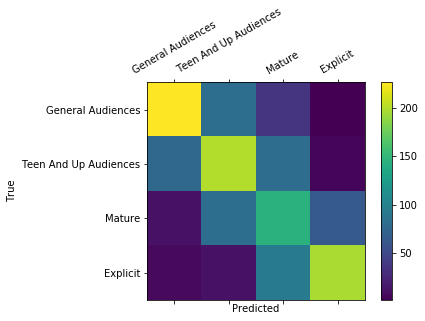

[346 364 305 310]
[0.65606936 0.5521978  0.47540984 0.63870968]


In [156]:
# confusion matrix for 4 classes
from collections import Counter
labels = ['General Audiences', 'Teen And Up Audiences', 'Mature', 'Explicit']

# get y back to original form
ytest = le.inverse_transform(Y_test.argmax(axis=1)) 
ypred = le.inverse_transform(ynew1.argmax(axis=1))
#print(ytest[1:4])

# plot count of each category 
#sns.countplot(ytest)
#plt.xlabel('Label')
#plt.title('Number of fics in each rating')
#plt.show()

# count each category in Y_test
print(Counter(ytest))

# confusion matrix with numerical values of y
#cmn = confusion_matrix(Y_test.argmax(axis=1), ynew1.argmax(axis=1)) # true as rows and predicted as columns
#print(cmn)

# confustion matrix with original labels of y (after using inverse_transform)
cm = confusion_matrix(ytest, ypred, labels)
print(cm)

# plot the confusion matrix
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cm)
#plt.title('Confusion matrix of the classifier')
fig.colorbar(cax)

tick_marks = np.arange(len(labels))
plt.xticks(tick_marks, labels, rotation=30)
plt.yticks(tick_marks, labels)
#ax.set_xticklabels([''] + labels)
#ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

#plt.imshow(cm)
#plt.title('Confusion matrix of the classifier')
#plt.colorbar()
#plt.xlabel('Predicted')
#plt.ylabel('True')
#plt.show()

# accuracy for each class
#print(cm.diagonal)
print(cm.sum(axis=1))
print(cm.diagonal()/cm.sum(axis=1))

In [157]:
# get report on precision, recall, and f1-score
from sklearn.metrics import classification_report

y_test = np.argmax(Y_test, axis=1) # Convert one-hot to index
y_pred = model15.predict([test_sequences_matrix, test_seq3_mat]).argmax(axis=1)
#print(classification_report(y_test, y_pred)) #target_names=labels
print(classification_report(ytest, ypred, target_names=labels))


                       precision    recall  f1-score   support

    General Audiences       0.74      0.64      0.69       310
Teen And Up Audiences       0.70      0.66      0.68       346
               Mature       0.41      0.48      0.44       305
             Explicit       0.53      0.55      0.54       364

            micro avg       0.58      0.58      0.58      1325
            macro avg       0.60      0.58      0.59      1325
         weighted avg       0.60      0.58      0.59      1325



In [131]:
# building a combination of CNN and RNN
batch_size = 128
nb_filter = 256
filter_length = 5
hidden_dims = nb_filter * 2
nb_epoch = 7 # 60
RNN = GRU
rnn_output_size = 100
folds = 10

# maxlen = X_train.shape[1]
# max_features = len(W)
# embedding_dims = len(W[0])

def model_comb():
    main_input = Input(shape=(max_len, ), name='main_input') # dtype='int32'
    embedding = Embedding(max_words, 100, weights=[embedding_matrix], name='embedding', input_length=max_len)(main_input)
    #embedding  = Embedding(max_features, embedding_dims, weights=[np.matrix(W)], input_length=maxlen, name='embedding')(main_input)

    embedding = Dropout(0.50)(embedding)
    #embedding = Flatten()(embedding)

    conv4 = Conv1D(nb_filter, filter_length, border_mode='valid', subsample_length=1,
                   activation='relu', name='conv4')(embedding)
    maxConv4 = MaxPooling1D(2, name='maxConv4')(conv4)
    maxConv4 = Flatten()(maxConv4)

    conv5 = Conv1D(nb_filter, filter_length, border_mode='valid', subsample_length=1,
                   activation='relu', name='conv5')(embedding)
    maxConv5 = MaxPooling1D(2, name='maxConv5')(conv5)
    maxConv5= Flatten()(maxConv5)

    x = concatenate([maxConv4, maxConv5])
    x = Dropout(0.15)(x)

    #x = RNN(rnn_output_size)(x)

    x = Dense(hidden_dims, activation='relu', init='he_normal',
              W_constraint = maxnorm(3), b_constraint=maxnorm(3),
              name='mlp')(x)
    x = Dropout(0.10, name='drop')(x)
    output = Dense(4, init='he_normal', activation='softmax', name='output')(x)
    
    model = Model(input=main_input, output=output)
    return model


In [132]:
# compile the combined model 3
model3 = model_comb()

model3.compile(loss={'output':'categorical_crossentropy'},
                optimizer='adam',
                metrics=["accuracy"])

# train the model
model3.fit(sequences_matrix, Y_train, batch_size=n_batch, epochs=n_epochs, validation_split=0.125, shuffle=True)

# evaluate
accr3 = model3.evaluate(test_sequences_matrix,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr3[0],accr3[1]))

C:\Users\chau0\Anaconda3\envs\py35\lib\site-packages\ipykernel_launcher.py:24: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(256, 5, activation="relu", name="conv4", strides=1, padding="valid")`
C:\Users\chau0\Anaconda3\envs\py35\lib\site-packages\ipykernel_launcher.py:29: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(256, 5, activation="relu", name="conv5", strides=1, padding="valid")`
C:\Users\chau0\Anaconda3\envs\py35\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(512, activation="relu", name="mlp", kernel_initializer="he_normal", kernel_constraint=<keras.con..., bias_constraint=<keras.con...)`
C:\Users\chau0\Anaconda3\envs\py35\lib\site-packages\ipykernel_launcher.py:42: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(4, activation="softmax", name="output", kernel_initializer="he_normal")`
C:\Users\chau0\Anaconda3\envs\py35\lib\site-packages\ipykernel_launcher.py

Train on 10427 samples, validate on 1490 samples
Epoch 1/7
10427/10427 [==============================] - 165s 16ms/step - loss: 11.8167 - acc: 0.2574 - val_loss: 11.9239 - val_acc: 0.2591
Epoch 2/7
10427/10427 [==============================] - 158s 15ms/step - loss: 11.9636 - acc: 0.2574 - val_loss: 11.9235 - val_acc: 0.2591
Epoch 3/7
10427/10427 [==============================] - 165s 16ms/step - loss: 11.9630 - acc: 0.2574 - val_loss: 11.9232 - val_acc: 0.2591
Epoch 4/7
10427/10427 [==============================] - 152s 15ms/step - loss: 11.9624 - acc: 0.2575 - val_loss: 11.9231 - val_acc: 0.2591
Epoch 5/7
10427/10427 [==============================] - 151s 14ms/step - loss: 11.9621 - acc: 0.2575 - val_loss: 11.9232 - val_acc: 0.2591
Epoch 6/7
 4480/10427 [===========>..................] - ETA: 1:28 - loss: 11.8411 - acc: 0.2650

KeyboardInterrupt: 